In [1]:
import pandas as pd
from glob import glob
import math
import numpy as np
from skimage import io, morphology, img_as_ubyte, img_as_float, filters
import os
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from shapely.geometry import LineString, MultiPoint
from shapely.ops import split
from scipy import io as sio
from centerline import CenterLine, smooth_mask, iou

### Read centerlines from a .mat file produced by ctFIRE

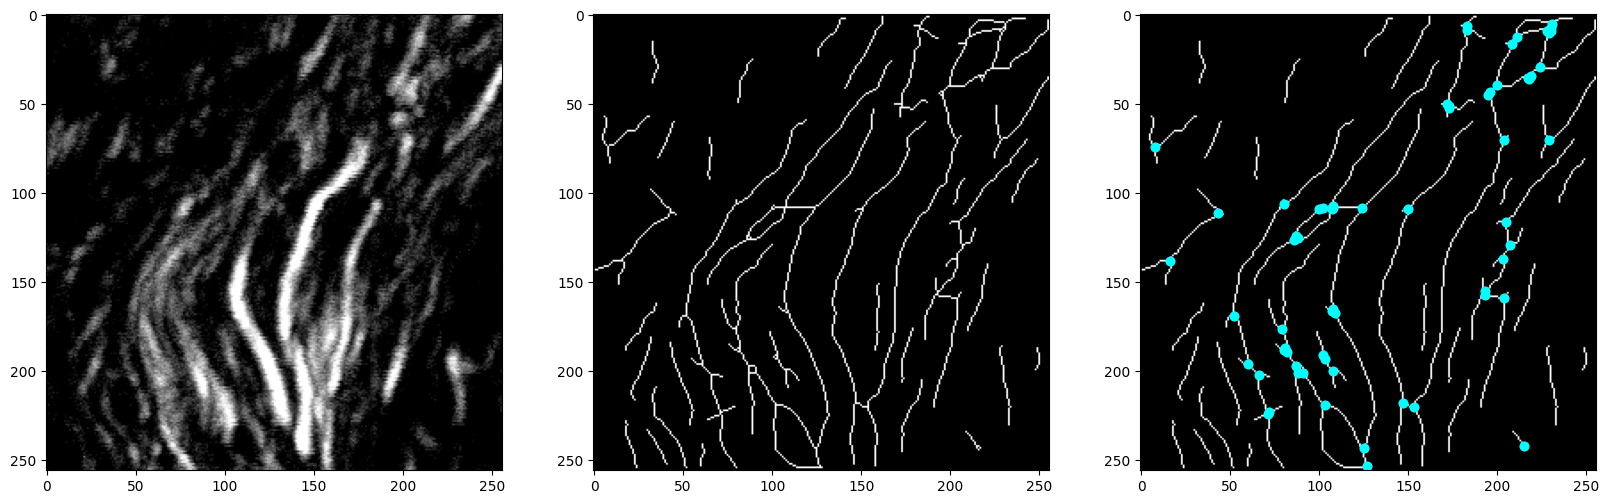

{'cir_mean': -1.4414746778986334, 'cir_var': 0.5221930776883312, 'len_mean': 41.436619718309856, 'len_var': 30.116081705728085, 'waviness': 0.3672102915367762, 'intensity': 2679}


In [2]:
mat = sio.loadmat('examples/sample_ctFIRE.mat')
mat_data = mat['data']
centerline_mat = CenterLine()
line_dict = centerline_mat.mat_to_lines(mat_data)
centerline_mat = CenterLine(line_dict=line_dict, associate_image=io.imread("examples/sample_input.png"))
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(centerline_mat.associate_image, cmap=plt.cm.gray)
ax[1].imshow(centerline_mat.centerline_image, cmap=plt.cm.gray)
joints_coords, filtered_image = centerline_mat.joint_filter(centerline_mat.centerline_image)
ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
ax[2].imshow(filtered_image, cmap=plt.cm.gray)
ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
plt.show()
centerline_mat.export_line_dict('examples/example_image_ctFIRE_line_dict.csv')

### compute features from ctFIRE extracted centerline, note that the range of cir_mean is Pi (3.14, 5% error is ~0.15)
centerline_mat.compute_fiber_feats() 
print(dict(list(centerline_mat.feats.items())[:-1]))

### Run ridge detector on a image

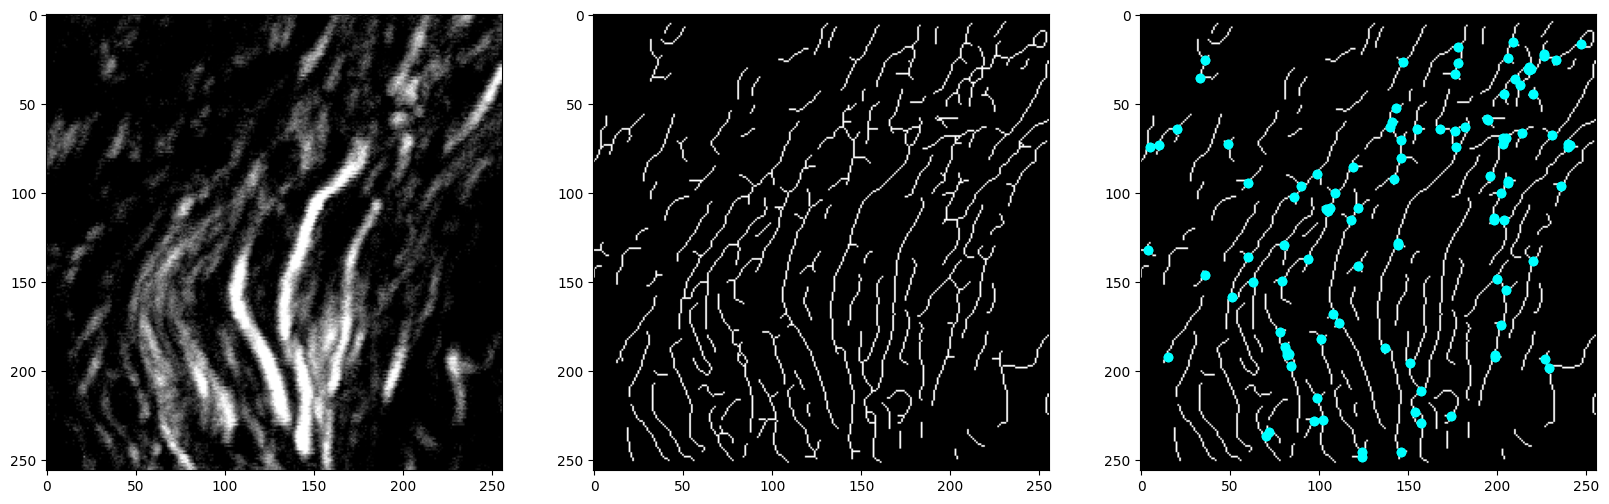

{'cir_mean': -1.3371664151257532, 'cir_var': 0.5803777889453595, 'len_mean': 12.844884488448844, 'len_var': 10.970062707739624, 'waviness': 0.33902506079146394, 'intensity': 3672}


In [3]:
centerline_ridge = CenterLine(associate_image=io.imread("examples/sample_input.png"))
line_dict = centerline_ridge.ridge_detector(config_fname="ridge_detector_params.json")
centerline_ridge = CenterLine(line_dict=line_dict, associate_image=io.imread("examples/sample_input.png"))
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(centerline_ridge.associate_image, cmap=plt.cm.gray)
ax[1].imshow(centerline_ridge.centerline_image, cmap=plt.cm.gray)
joints_coords, filtered_image = centerline_ridge.joint_filter(centerline_ridge.centerline_image)
ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
ax[2].imshow(filtered_image, cmap=plt.cm.gray)
ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
plt.show()
centerline_ridge.export_line_dict('examples/example_image_ridge_line_dict.csv')
centerline_ridge.compute_fiber_feats() 
print(dict(list(centerline_ridge.feats.items())[:-1]))

## Skeletonize a raw input

Draw masks using skeletonization


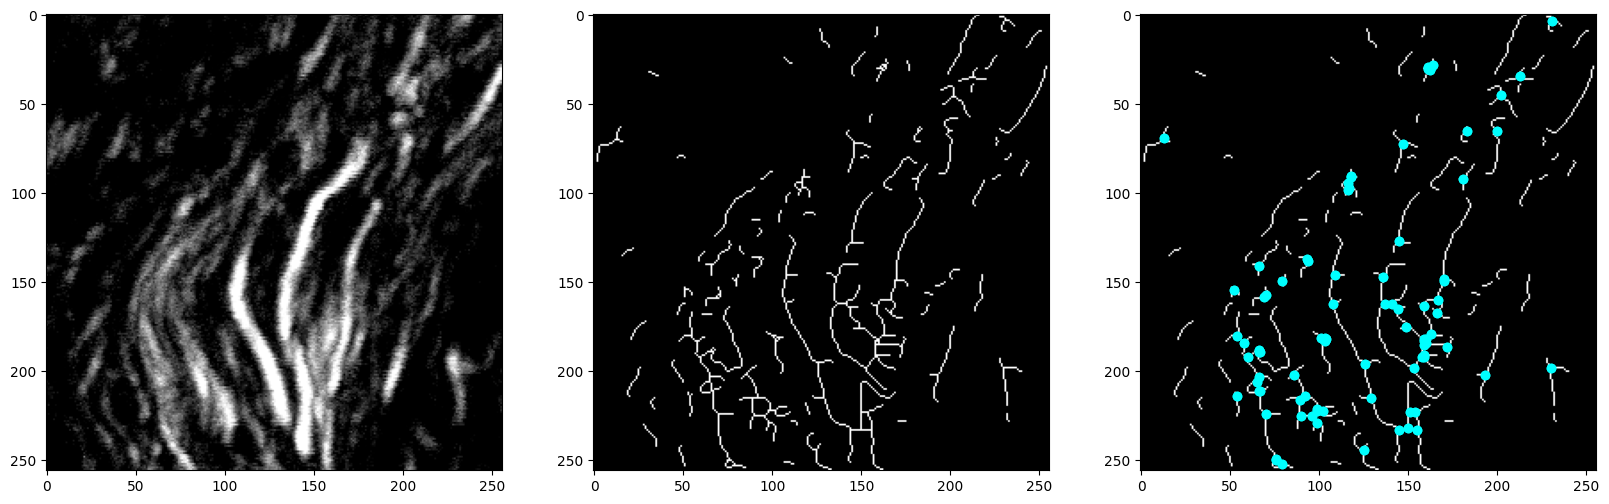

{'cir_mean': -1.3562861449619246, 'cir_var': 0.8332744006864352, 'len_mean': 11.375661375661375, 'len_var': 9.926270004528078, 'waviness': 0.47063255996164577, 'intensity': 1942}


In [4]:
centerline_raw = CenterLine(associate_image=io.imread("examples/sample_input.png"), draw_from_raw=True)
# centerline_raw = CenterLine(line_dict=centerline_raw.line_dict, associate_image=io.imread("examples/sample_input.png"))
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(centerline_raw.associate_image, cmap=plt.cm.gray)
ax[1].imshow(centerline_raw.centerline_image, cmap=plt.cm.gray)
joints_coords, filtered_image = centerline_raw.joint_filter(centerline_raw.centerline_image)
ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
ax[2].imshow(filtered_image, cmap=plt.cm.gray)
ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
plt.show()
centerline_raw.export_line_dict('examples/example_image_ridge_line_dict.csv')
centerline_raw.compute_fiber_feats() 
print(dict(list(centerline_raw.feats.items())[:-1]))

### Skeletonize a network output

Draw masks using skeletonization


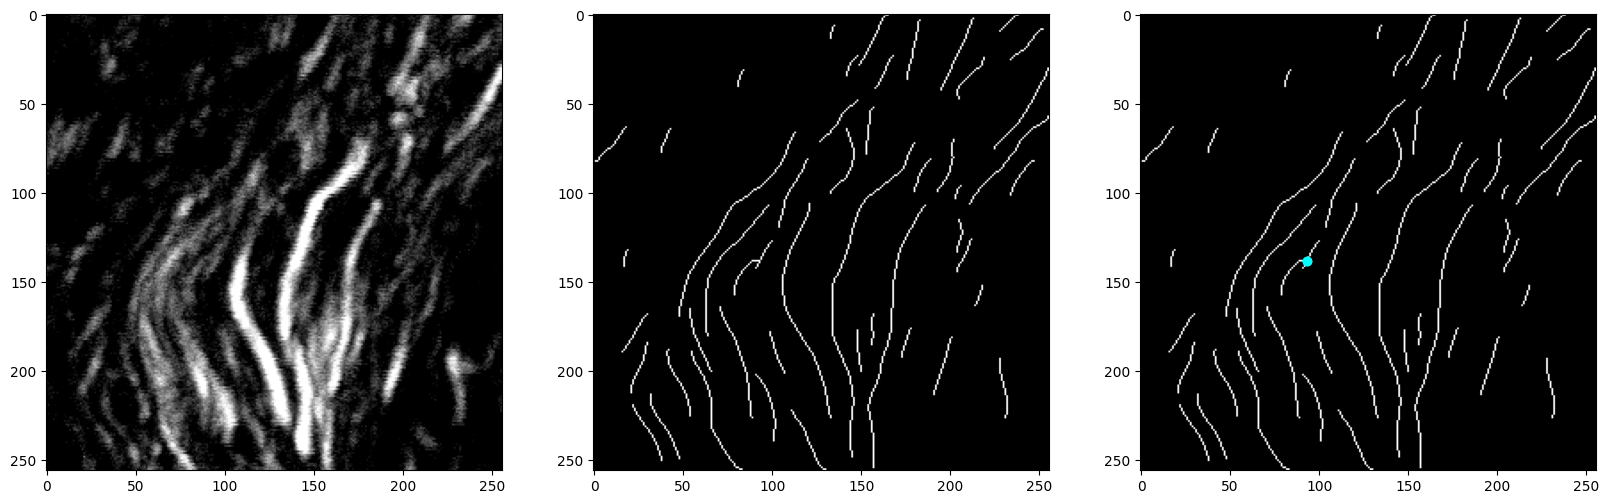

Network results:
{'cir_mean': -1.2126456602564757, 'cir_var': 0.33200234586694843, 'len_mean': 37.5, 'len_var': 34.69827085028878, 'waviness': 0.2992075909653172, 'intensity': 1837}


In [5]:
# vectorization using skimage skeletonization
img = img_as_float( io.imread("examples/sample_network-raw.png") ) # pre-obtained raw network output
binary = img > filters.threshold_otsu((img))
centerline_res = CenterLine(associate_image=binary, draw_from_raw=True) # pre-obtained raw network output
centerline_res = CenterLine(line_dict=centerline_res.line_dict, associate_image=io.imread("examples/sample_input.png"))
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(centerline_res.associate_image, cmap=plt.cm.gray)
ax[1].imshow(centerline_res.centerline_image, cmap=plt.cm.gray)
joints_coords, filtered_image = centerline_res.joint_filter(centerline_res.centerline_image)
ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
ax[2].imshow(filtered_image, cmap=plt.cm.gray)
ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
plt.show()
print('Network results:')
centerline_res.compute_fiber_feats()
print(dict(list(centerline_res.feats.items())[:-1]))

### Ground truth

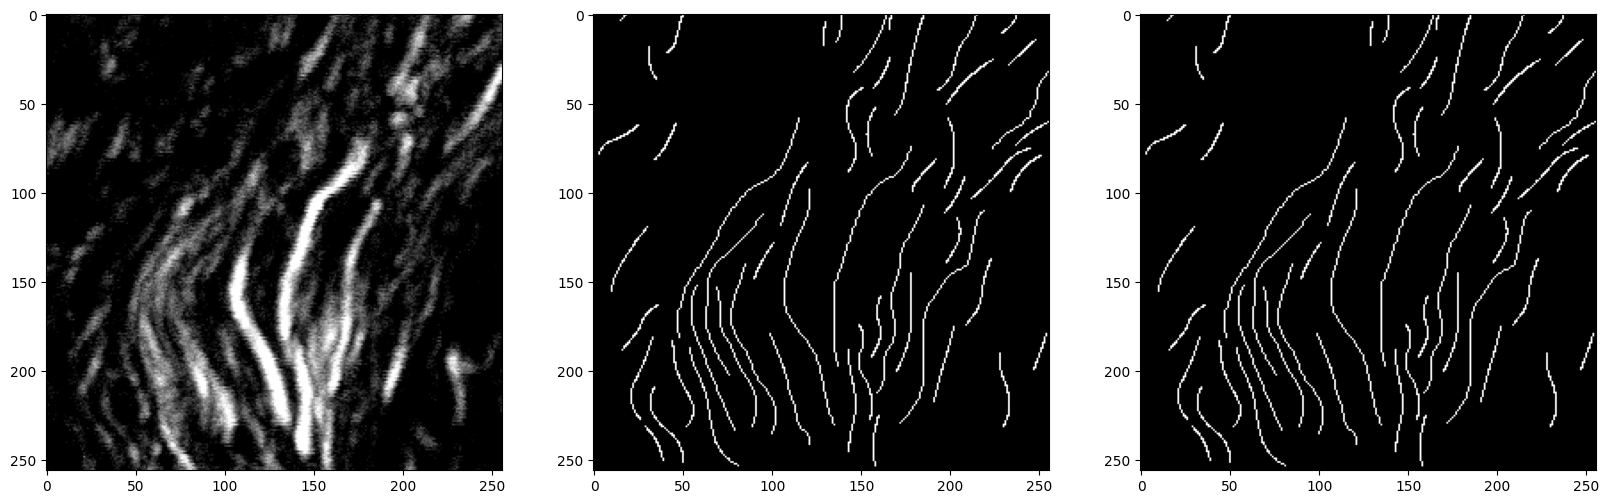

Ground truth:
{'cir_mean': -1.3845256444525234, 'cir_var': 0.4290187215168977, 'len_mean': 50.320754716981135, 'len_var': 31.122262604429675, 'waviness': 0.5253660288138319, 'intensity': 2667}


In [6]:
# Ground truth
centerline = CenterLine(centerline_image=io.imread("examples/sample_groundtruth.png"), associate_image=io.imread("examples/sample_input.png"))
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(centerline.associate_image, cmap=plt.cm.gray)
ax[1].imshow(centerline.centerline_image, cmap=plt.cm.gray)
joints_coords, filtered_image = centerline.joint_filter(centerline.centerline_image)
ax[2].imshow(filtered_image, cmap=plt.cm.gray)

if joints_coords.size > 0:
    ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
               linestyle='None', markersize=6)

plt.show()
print('Ground truth:')
centerline.compute_fiber_feats()
print(dict(list(centerline.feats.items())[:-1]))

### Check IoU and mask differences

ctFIRE
IoU: 0.48268821133797996


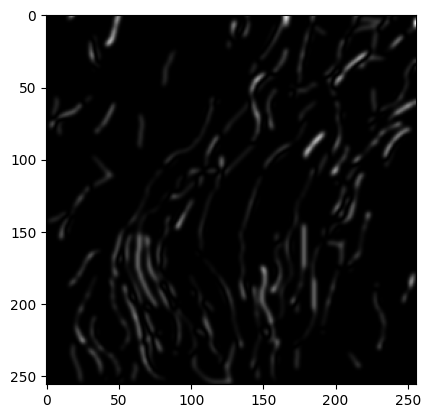

Ridge detector
IoU: 0.5574145000896101


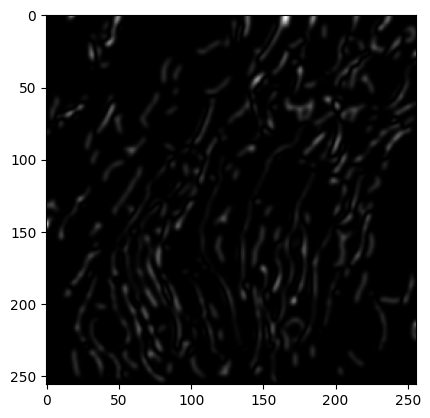

Network
IoU: 0.6245334590235525


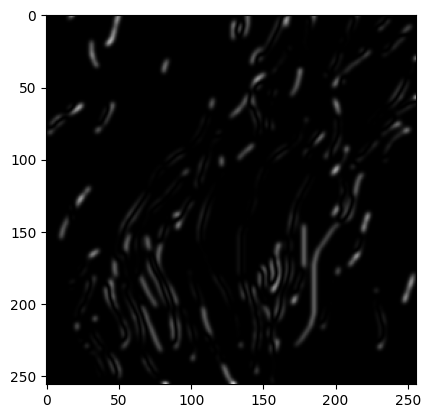

In [7]:
ratio, U, I = iou(smooth_mask(centerline.centerline_image), smooth_mask(centerline_mat.centerline_image), soft=True)
print('ctFIRE')
print(f'IoU: {ratio}')
plt.imshow(U-I, cmap='gray', vmin=0, vmax=1)
plt.show()
ratio, U, I = iou(smooth_mask(centerline.centerline_image), smooth_mask(centerline_ridge.centerline_image), soft=True)
print('Ridge detector')
print(f'IoU: {ratio}')
plt.imshow(U-I, cmap='gray', vmin=0, vmax=1)
plt.show()
ratio, U, I = iou(smooth_mask(centerline.centerline_image), smooth_mask(centerline_res.centerline_image), soft=True)
print('Network')
print(f'IoU: {ratio}')
plt.imshow(U-I, cmap='gray', vmin=0, vmax=1)
plt.show()

### (Optional) Network output can also be vectorized using ridge detector

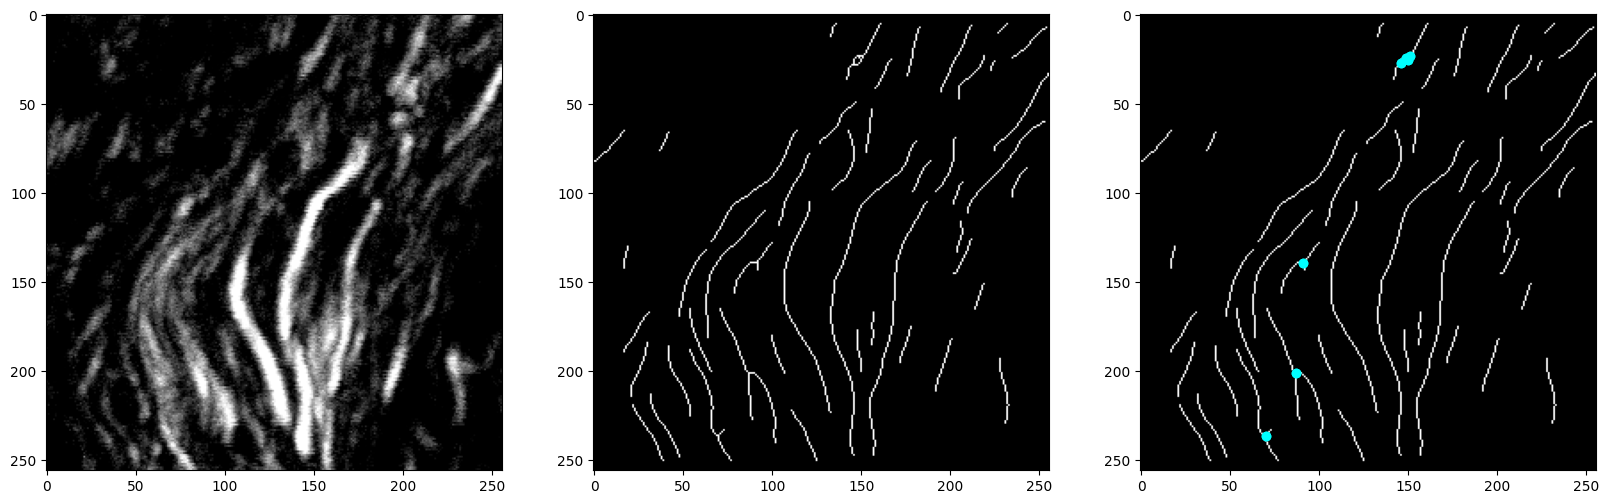

Network results:
{'cir_mean': -1.160400269470996, 'cir_var': 0.27808397801015583, 'len_mean': 22.152941176470588, 'len_var': 22.602189317358537, 'waviness': 0.2832197971443855, 'intensity': 1808}


In [8]:
# vectorization using ridge detector
img = img_as_float( io.imread("examples/sample_network-raw.png") )
binary = img > filters.threshold_mean((img))
centerline_res = CenterLine(associate_image=binary)
line_dict = centerline_res.ridge_detector(config_fname="ridge_detector_params.json")
centerline_res = CenterLine(line_dict=line_dict, associate_image=io.imread("examples/sample_input.png"))
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(centerline_res.associate_image, cmap=plt.cm.gray)
ax[1].imshow(centerline_res.centerline_image, cmap=plt.cm.gray)
joints_coords, filtered_image = centerline_res.joint_filter(centerline_res.centerline_image)
ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
ax[2].imshow(filtered_image, cmap=plt.cm.gray)
ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
plt.show()
print('Network results:')
centerline_res.compute_fiber_feats()
print(dict(list(centerline_res.feats.items())[:-1]))

### Create extraction results overlay

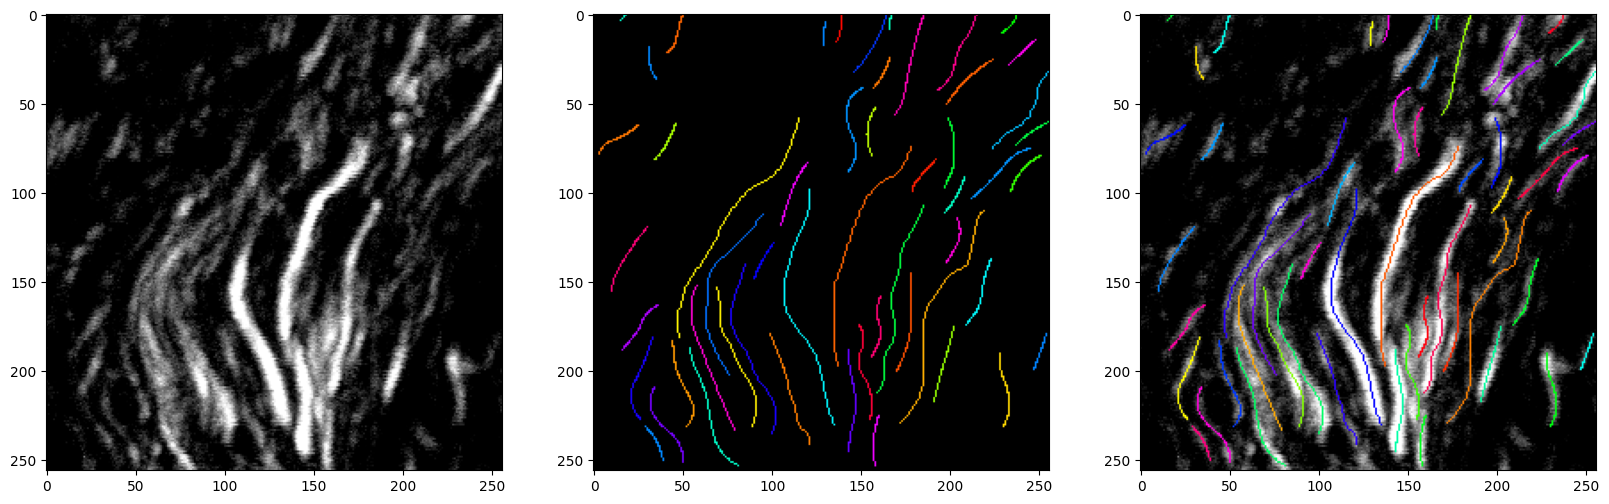

In [9]:
centerline.create_overlay()

### Visualize individual fiber extraction results

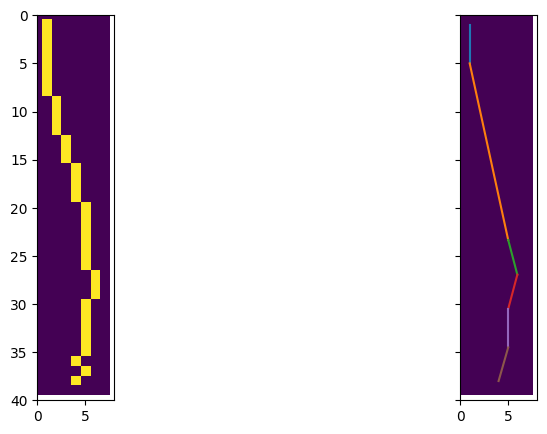

Length: 38.00, Waviness: 0.3740 



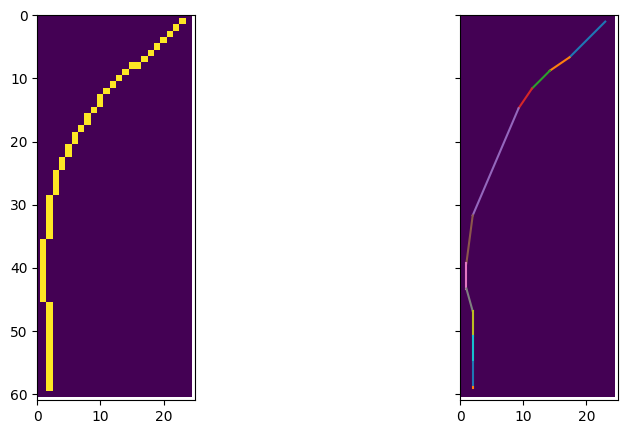

Length: 60.00, Waviness: 0.1792 



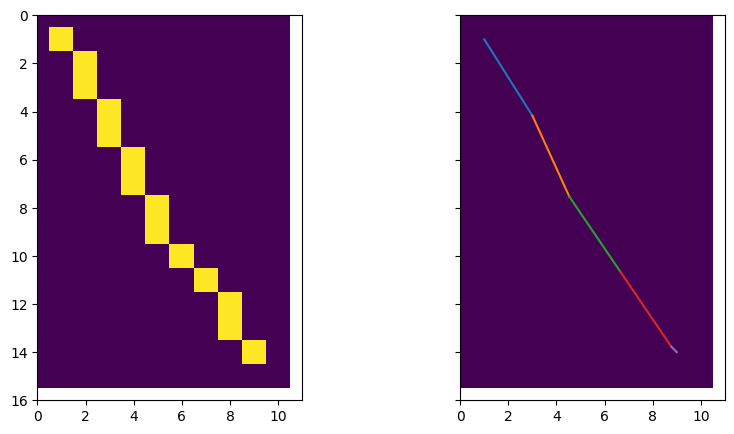

Length: 14.00, Waviness: 0.2954 



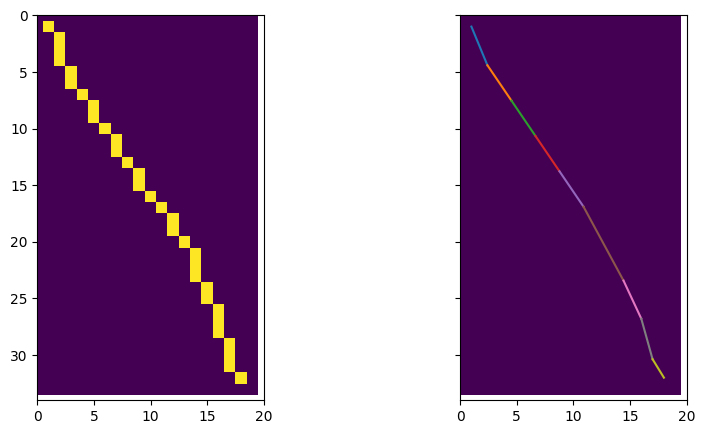

Length: 32.00, Waviness: 0.3175 



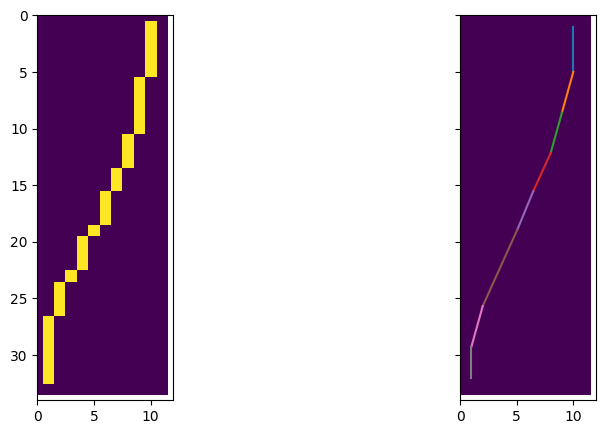

Length: 32.00, Waviness: 0.3283 



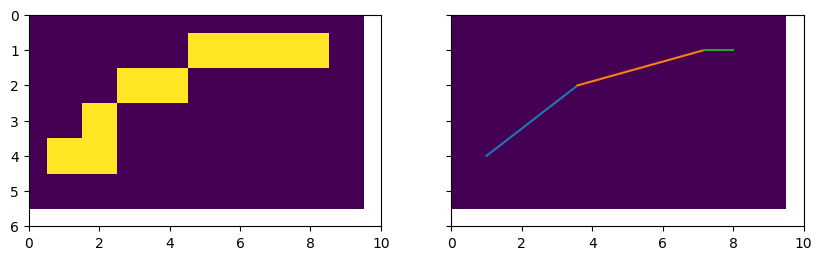

Length: 9.00, Waviness: 0.4989 



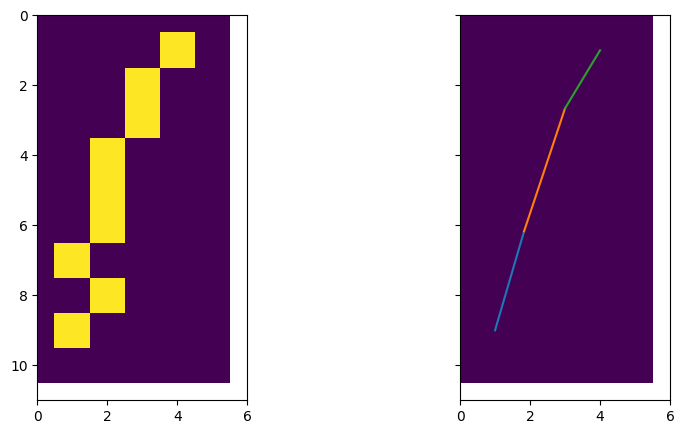

Length: 9.00, Waviness: 0.5578 



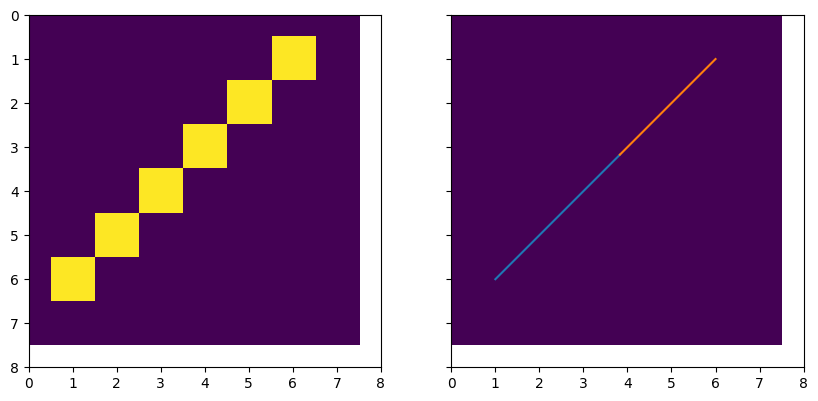

Length: 6.00, Waviness: 0.0000 



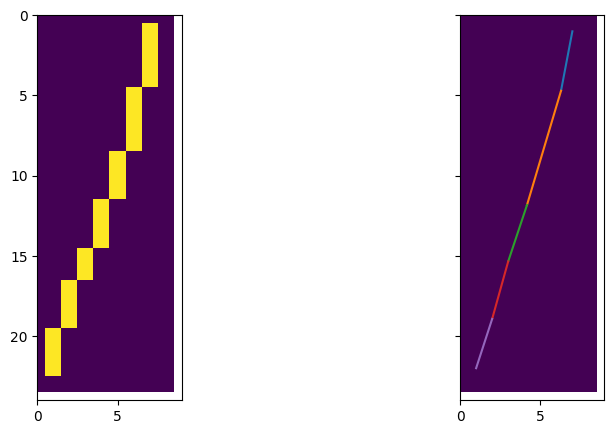

Length: 22.00, Waviness: 0.3313 



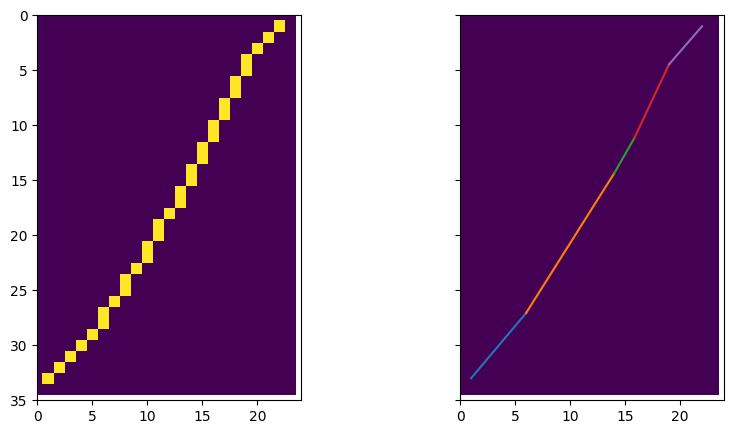

Length: 33.00, Waviness: 0.3009 



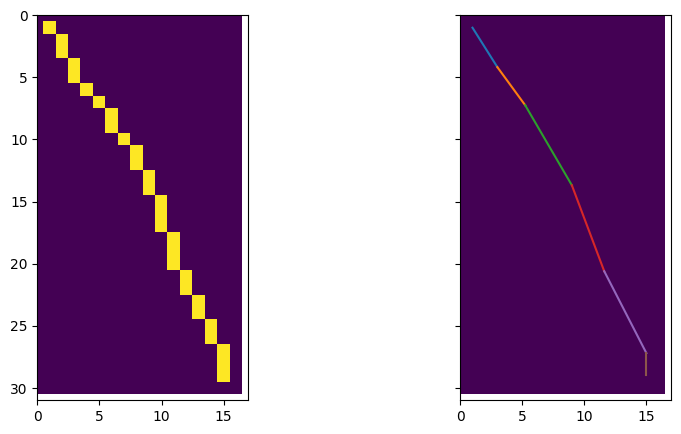

Length: 29.00, Waviness: 0.3310 



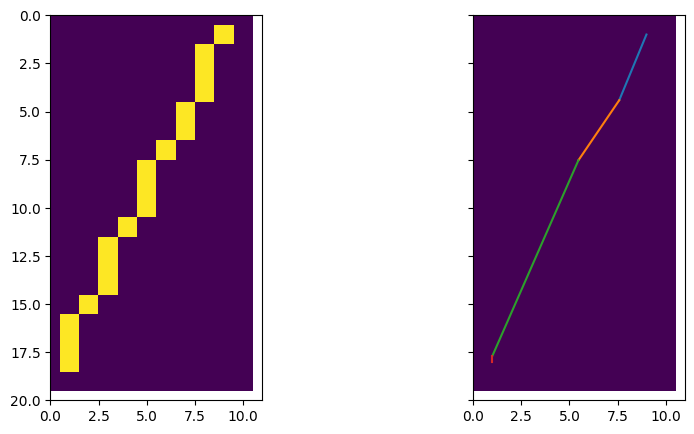

Length: 18.00, Waviness: 0.3418 



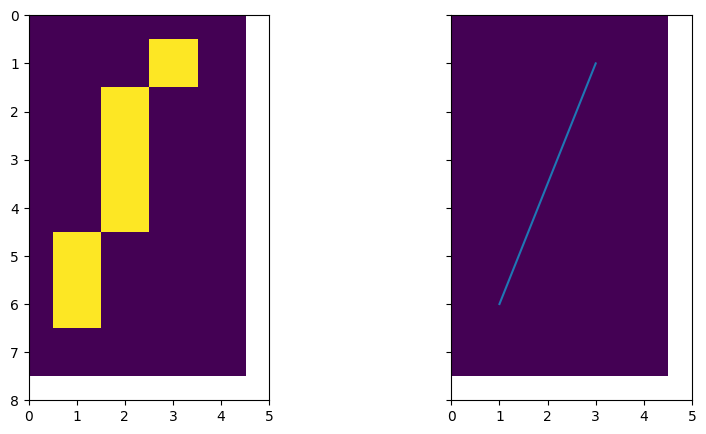

Length: 6.00, Waviness: 0.0000 



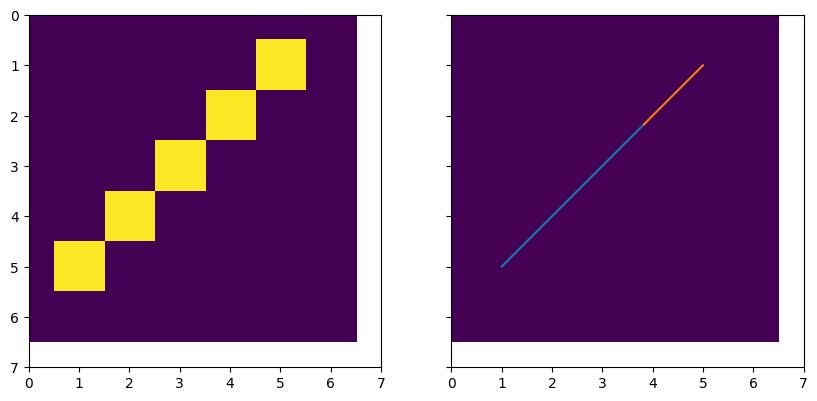

Length: 5.00, Waviness: 0.0000 



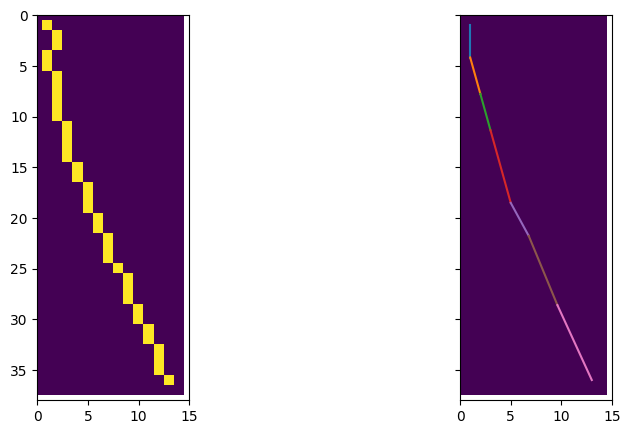

Length: 36.00, Waviness: 0.3914 



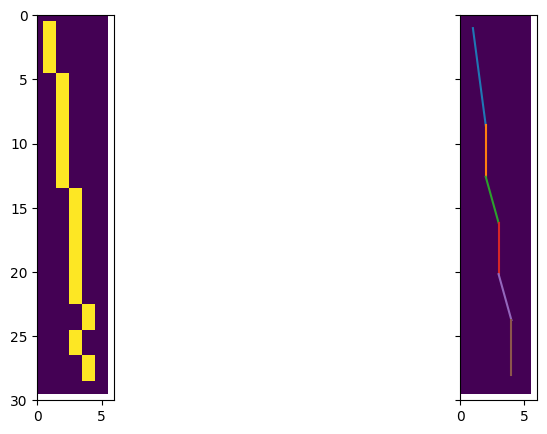

Length: 28.00, Waviness: 0.2698 



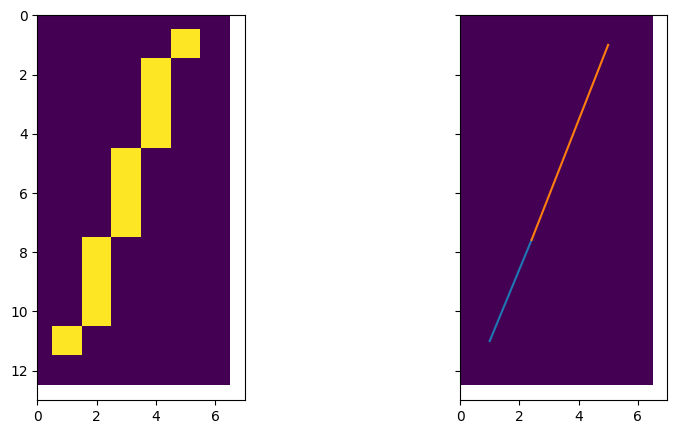

Length: 11.00, Waviness: 0.2952 



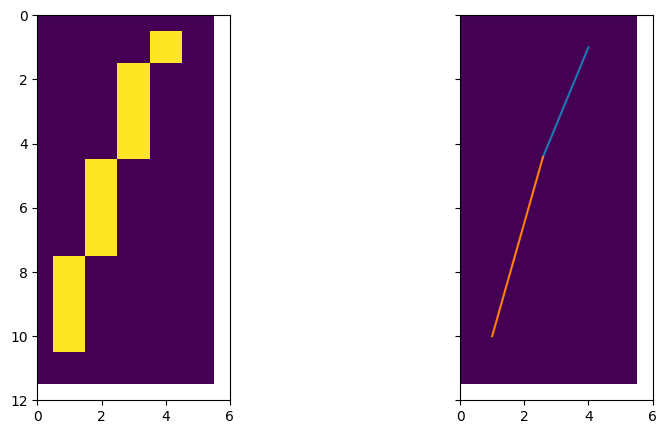

Length: 10.00, Waviness: 0.2869 



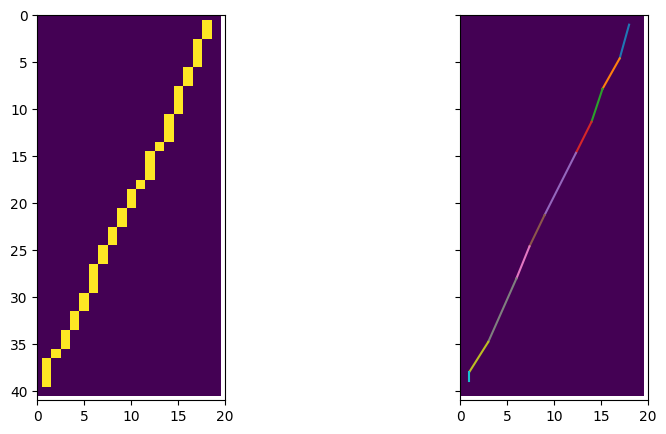

Length: 39.00, Waviness: 0.3552 



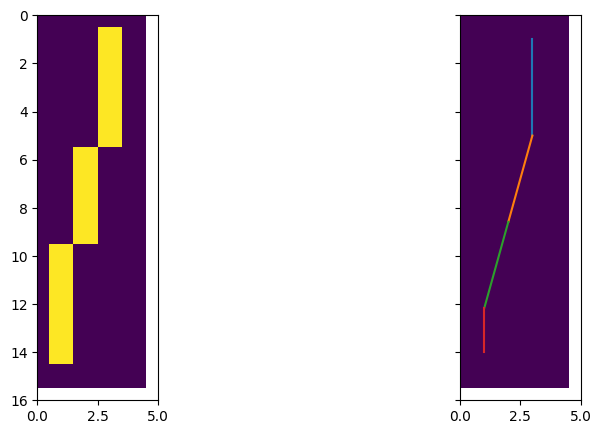

Length: 14.00, Waviness: 0.2674 



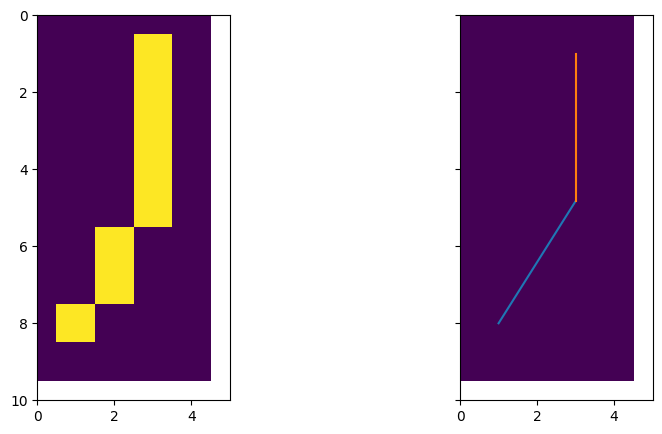

Length: 8.00, Waviness: 0.2731 



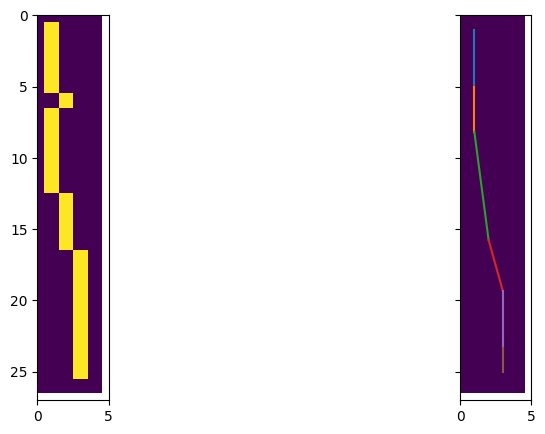

Length: 25.00, Waviness: 0.2925 



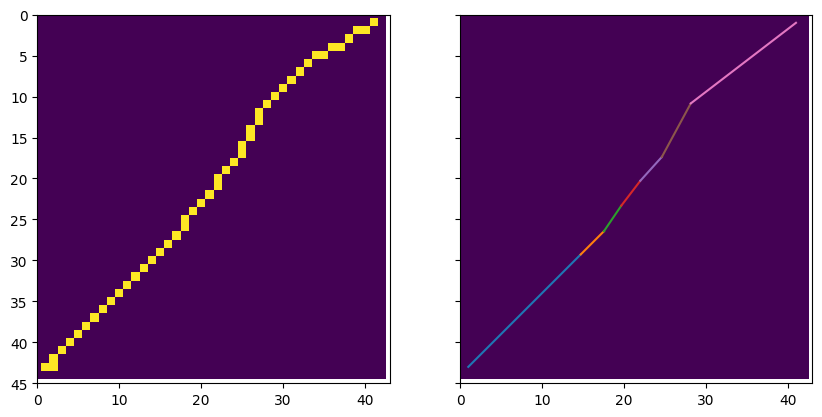

Length: 47.00, Waviness: 0.2199 



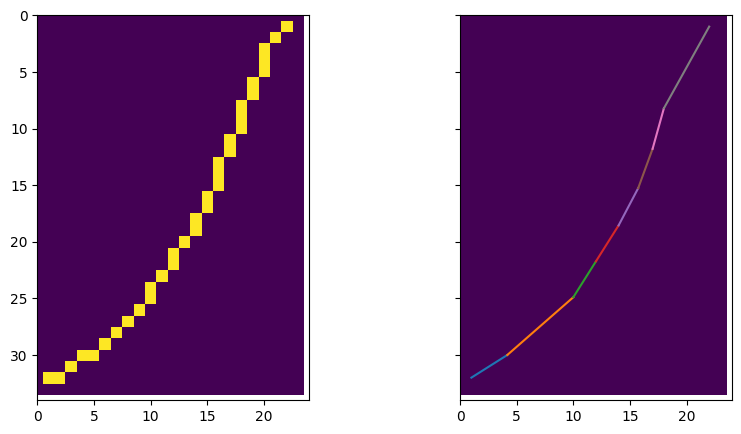

Length: 34.00, Waviness: 0.3159 



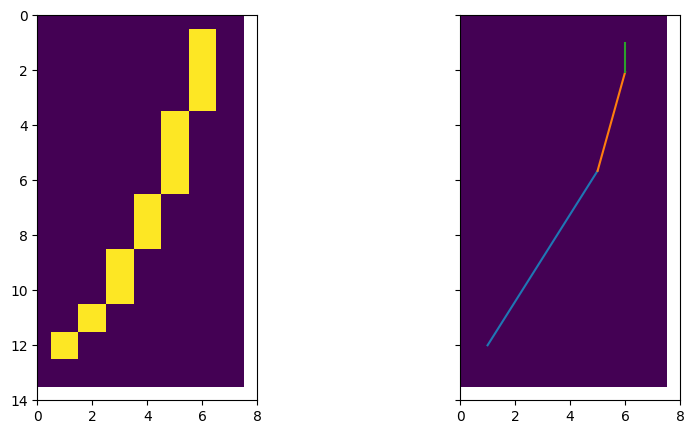

Length: 12.00, Waviness: 0.3188 



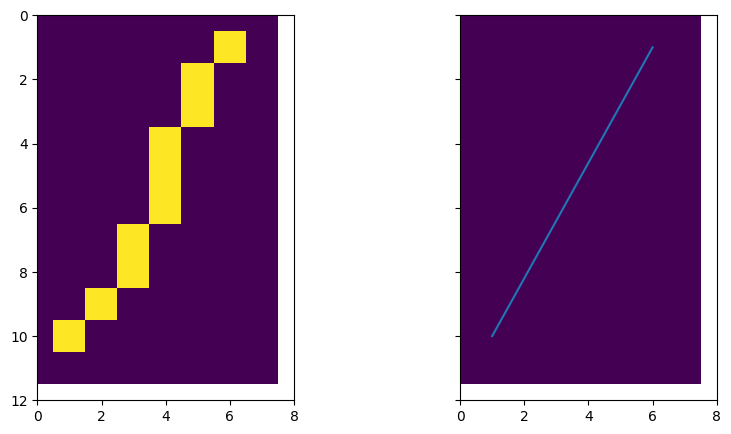

Length: 10.00, Waviness: 0.0000 



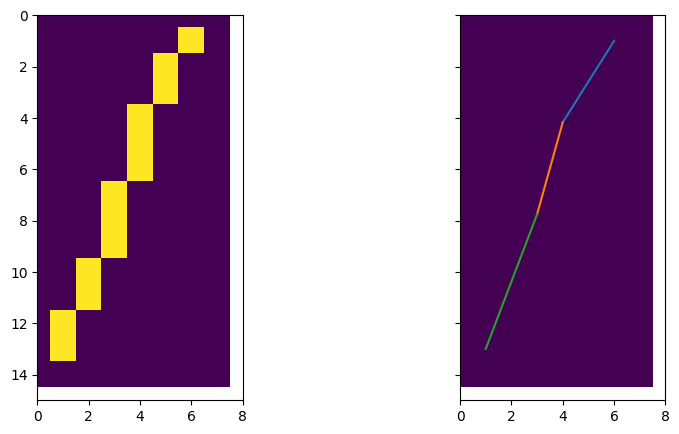

Length: 13.00, Waviness: 0.3383 



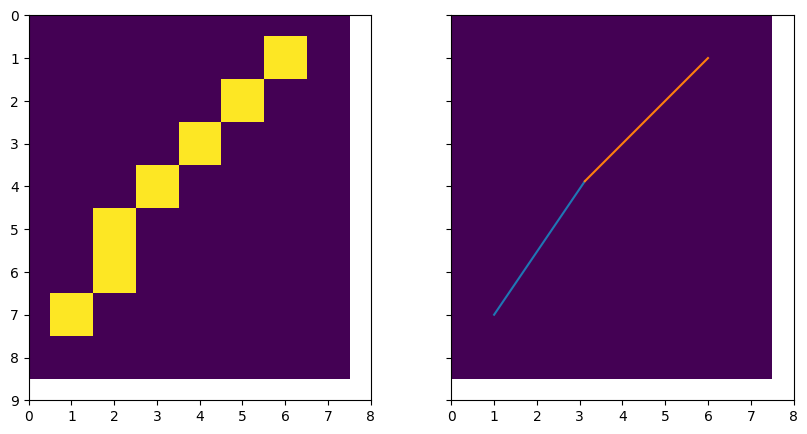

Length: 7.00, Waviness: 0.1285 



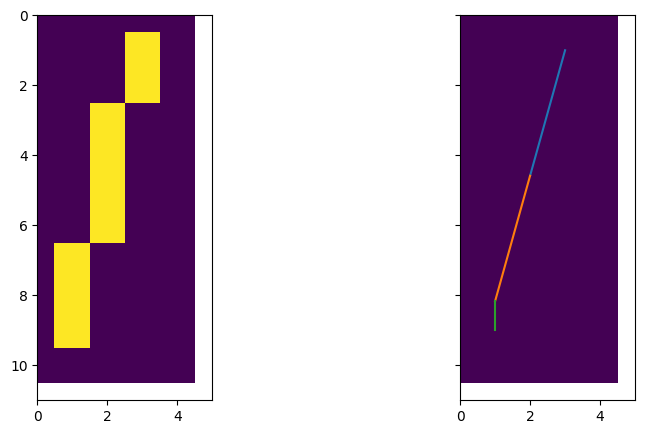

Length: 9.00, Waviness: 0.2985 



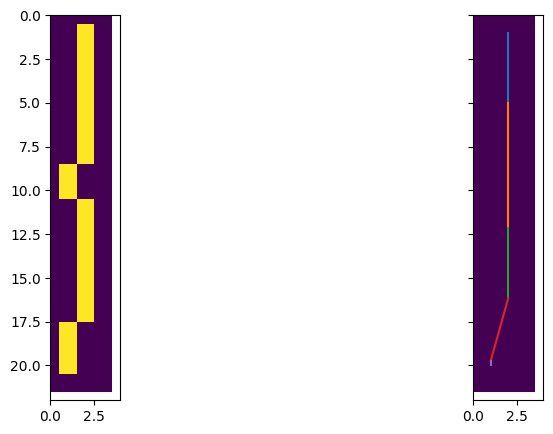

Length: 20.00, Waviness: 0.2802 



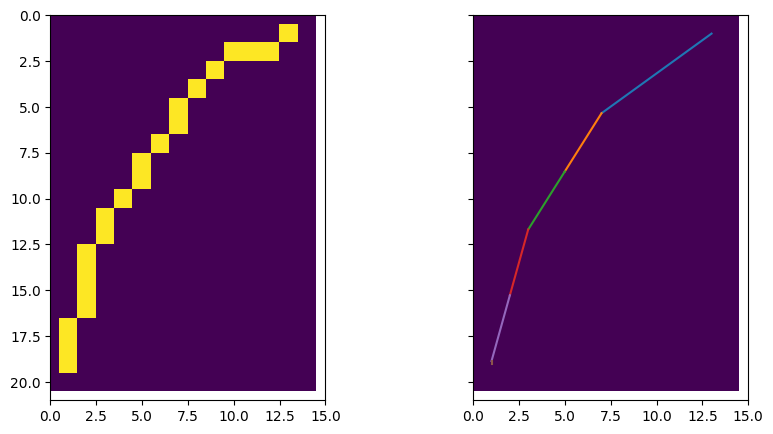

Length: 21.00, Waviness: 0.3478 



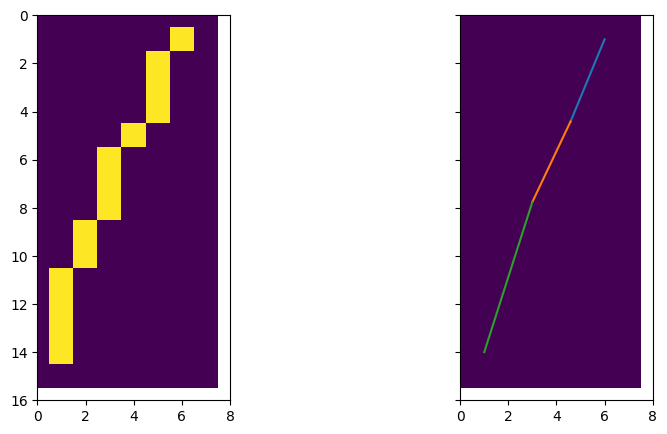

Length: 14.00, Waviness: 0.3395 



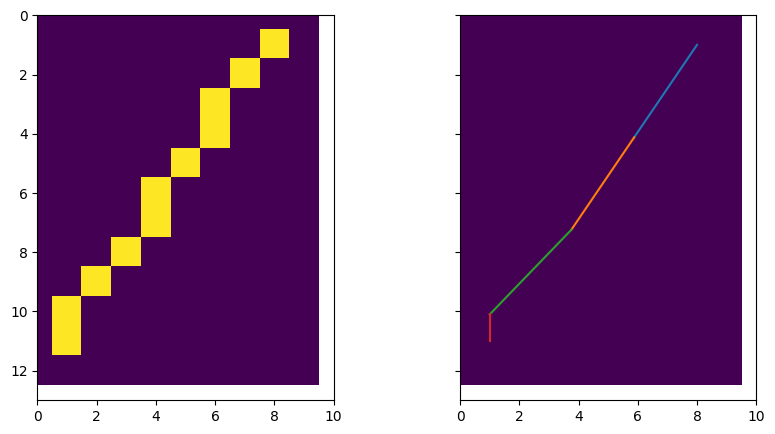

Length: 11.00, Waviness: 0.2234 



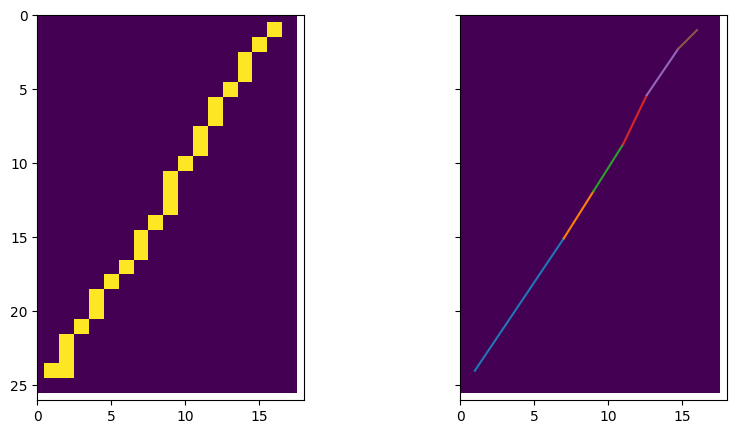

Length: 25.00, Waviness: 0.3257 



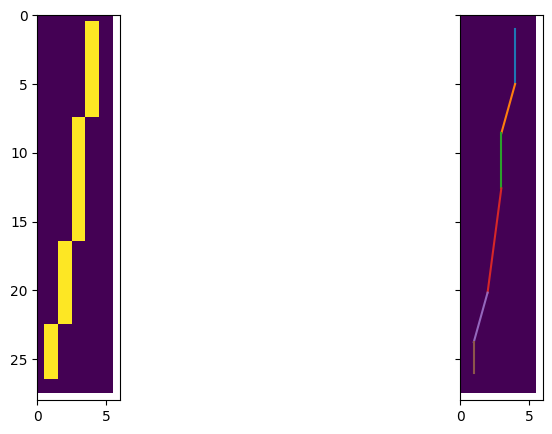

Length: 26.00, Waviness: 0.2075 



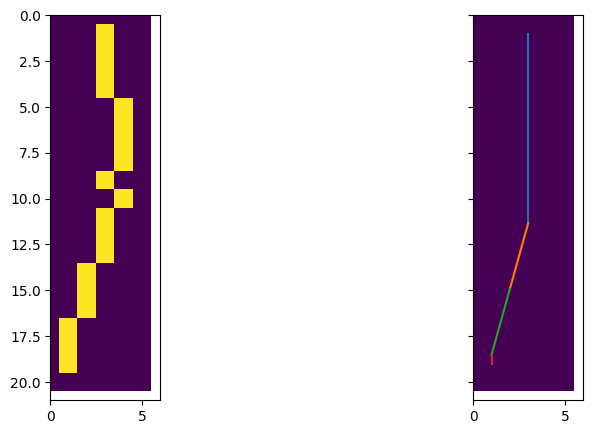

Length: 19.00, Waviness: 0.4075 



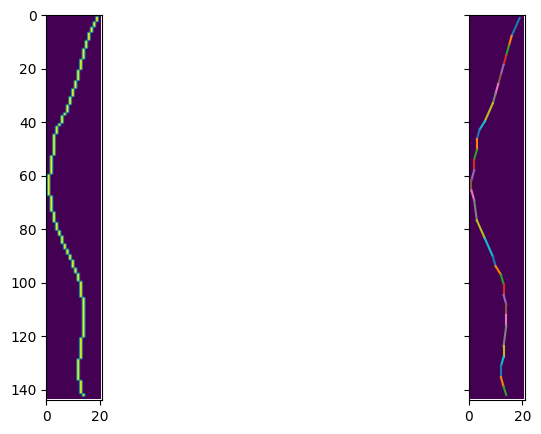

Length: 142.00, Waviness: 0.2786 



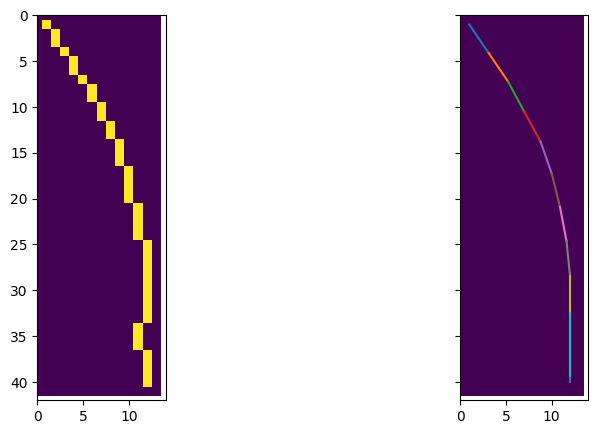

Length: 40.00, Waviness: 0.3022 



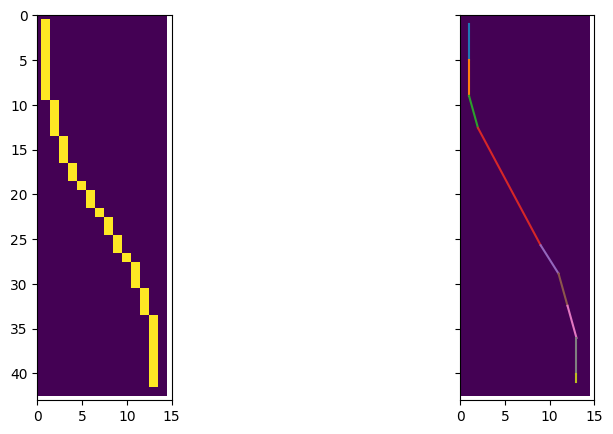

Length: 41.00, Waviness: 0.2637 



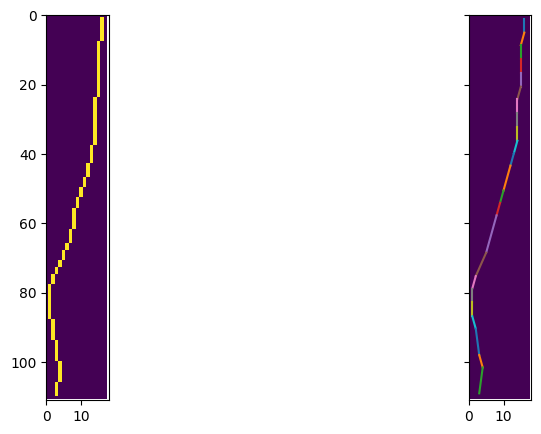

Length: 109.00, Waviness: 0.2213 



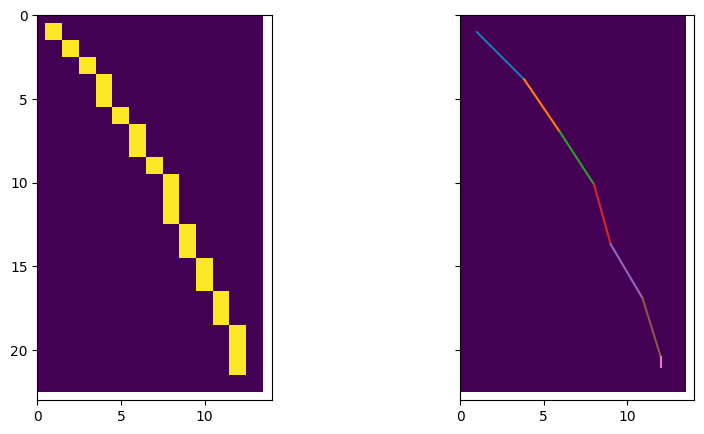

Length: 21.00, Waviness: 0.3157 



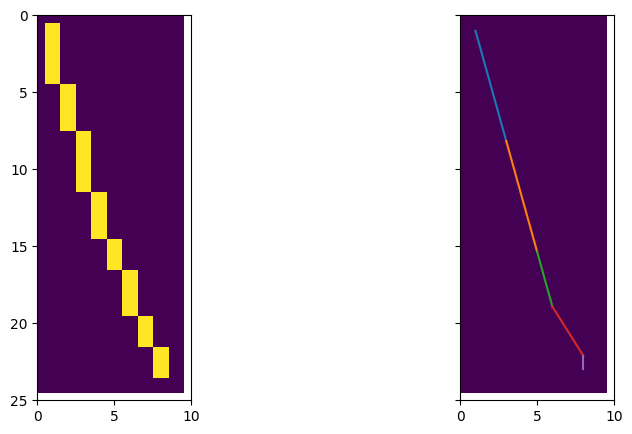

Length: 23.00, Waviness: 0.3398 



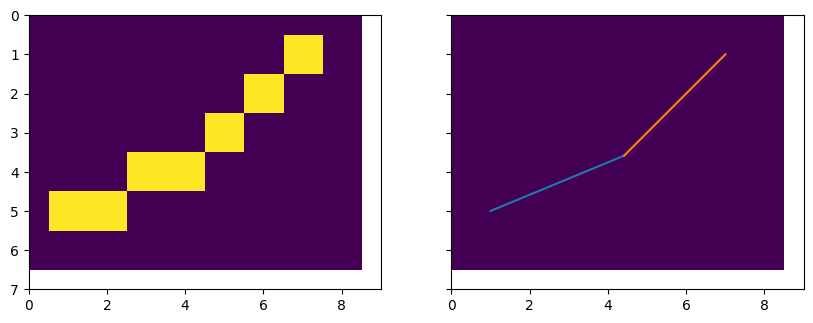

Length: 7.00, Waviness: 0.2287 



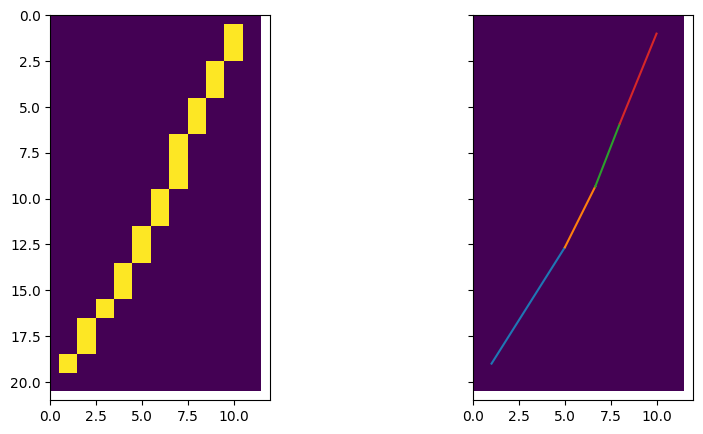

Length: 19.00, Waviness: 0.3387 



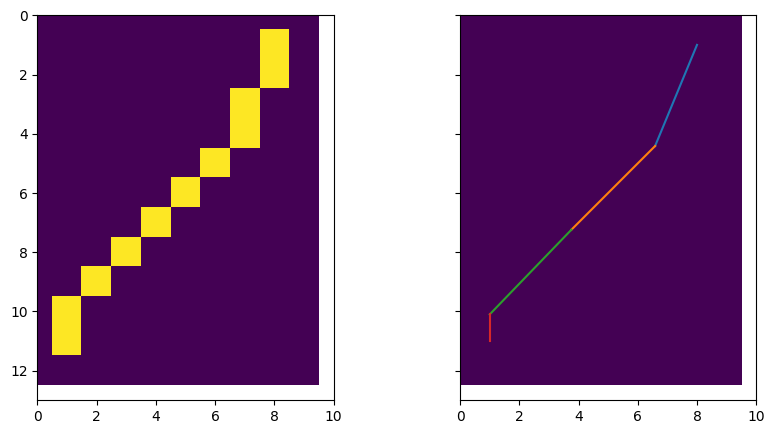

Length: 11.00, Waviness: 0.1728 



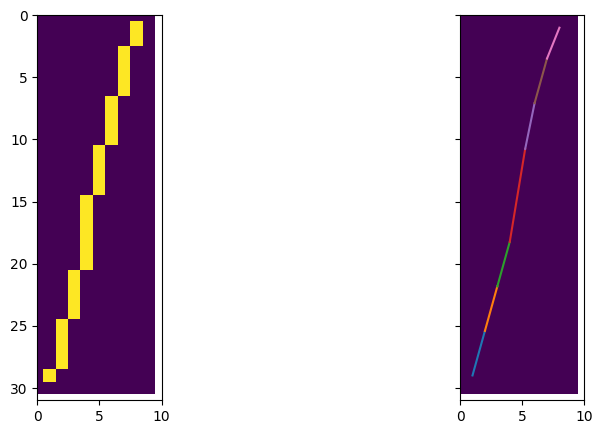

Length: 29.00, Waviness: 0.3055 



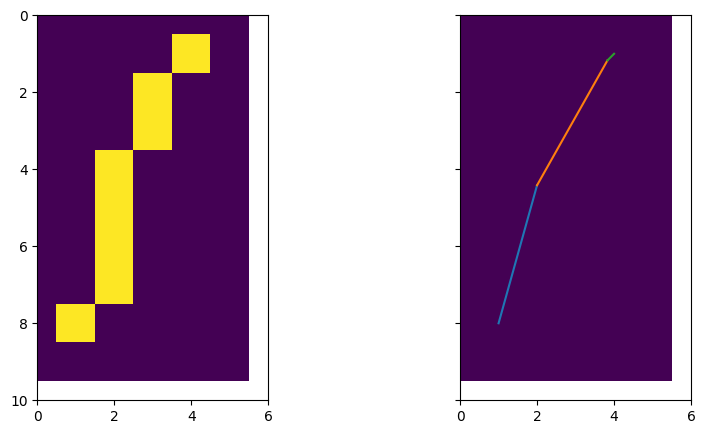

Length: 8.00, Waviness: 0.3305 



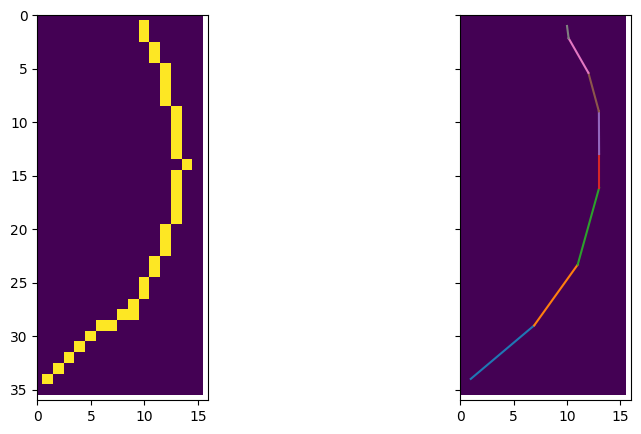

Length: 36.00, Waviness: 0.4303 



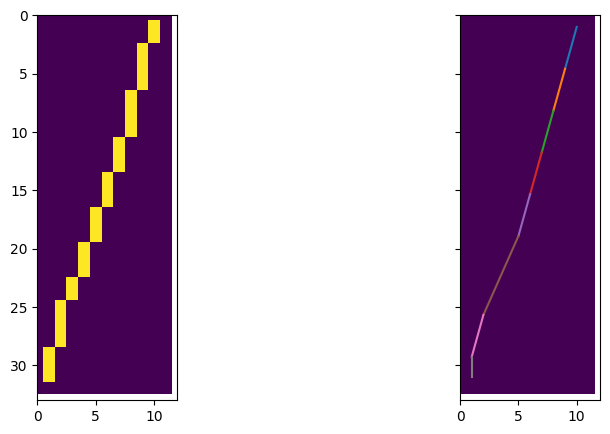

Length: 31.00, Waviness: 0.3351 



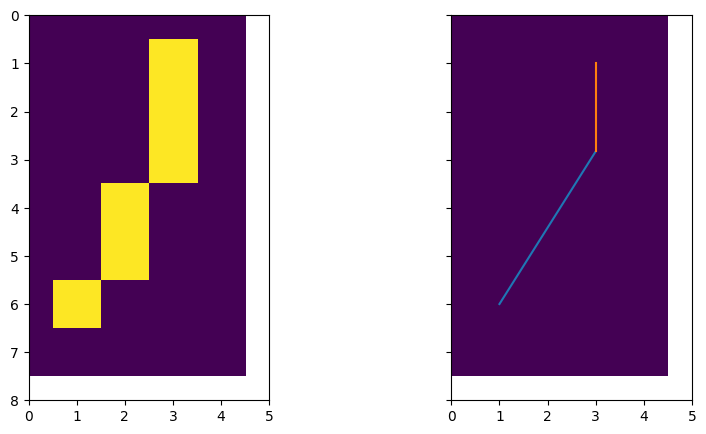

Length: 6.00, Waviness: 0.2952 



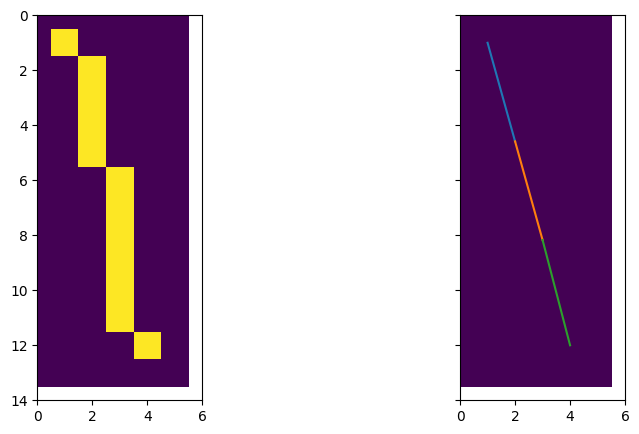

Length: 12.00, Waviness: 0.3104 



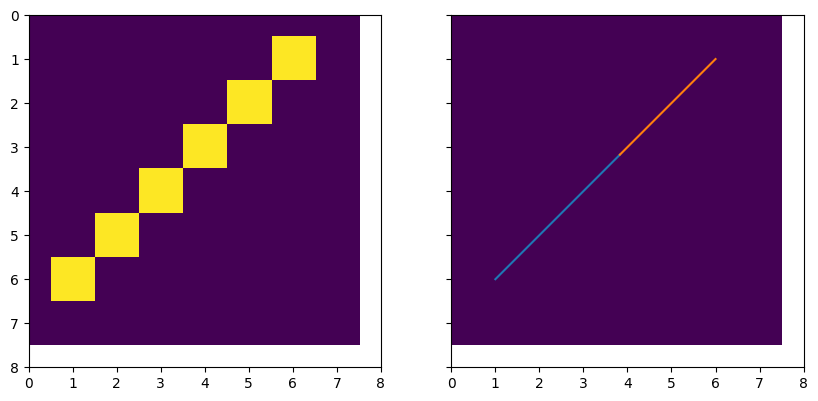

Length: 6.00, Waviness: 0.0000 



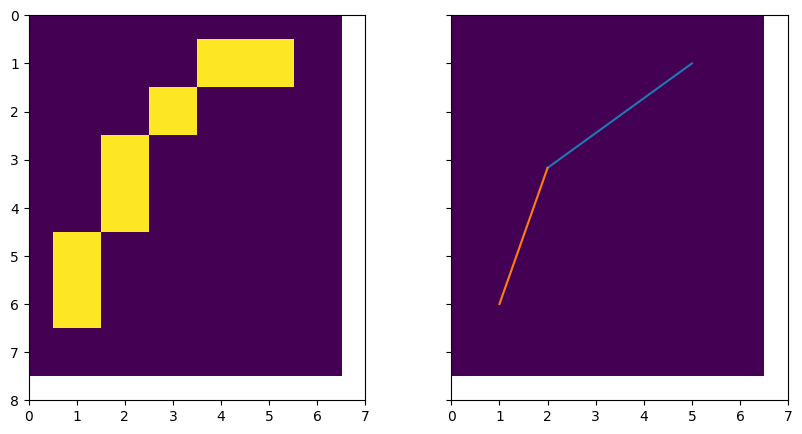

Length: 7.00, Waviness: 0.4331 



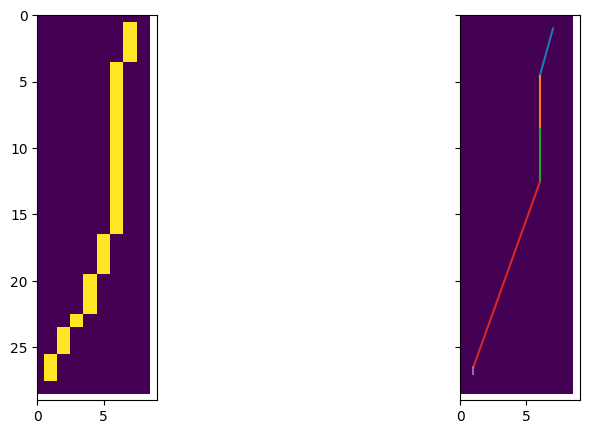

Length: 27.00, Waviness: 0.2414 



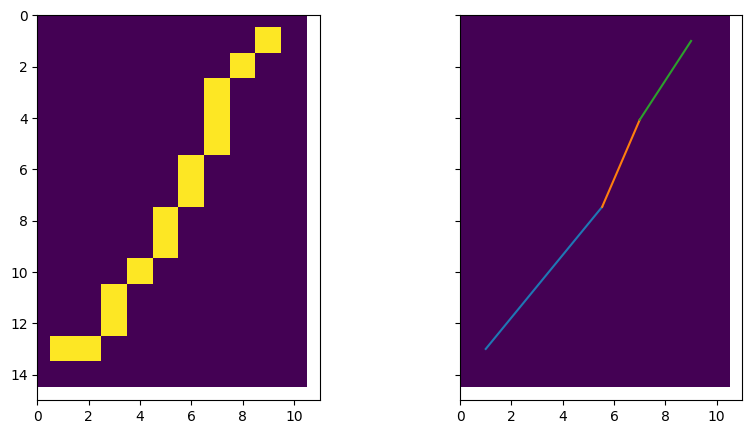

Length: 14.00, Waviness: 0.3963 



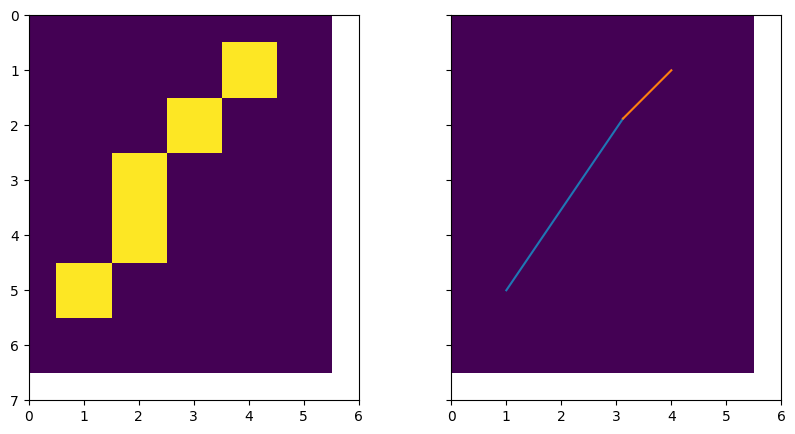

Length: 5.00, Waviness: 0.1830 



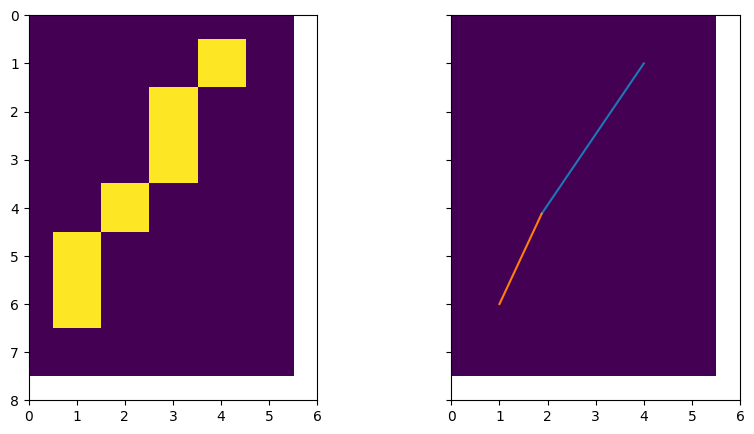

Length: 6.00, Waviness: 0.2578 



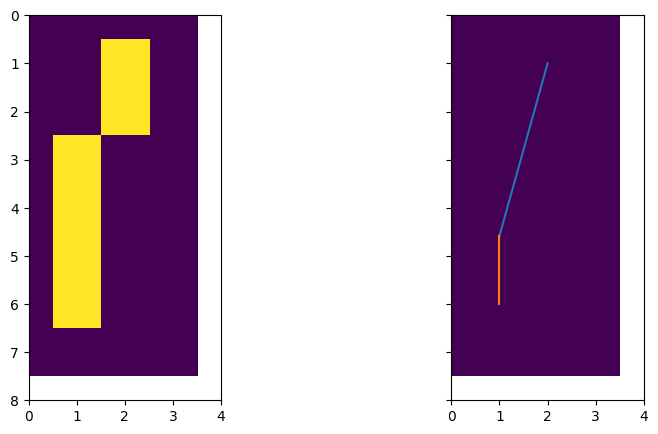

Length: 6.00, Waviness: 0.2287 



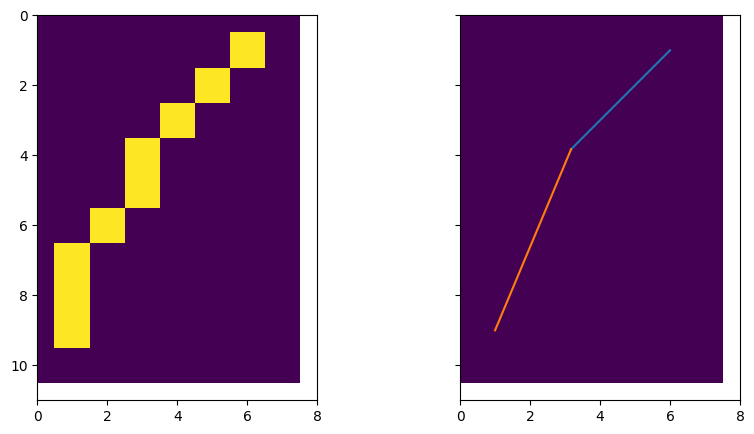

Length: 9.00, Waviness: 0.2478 



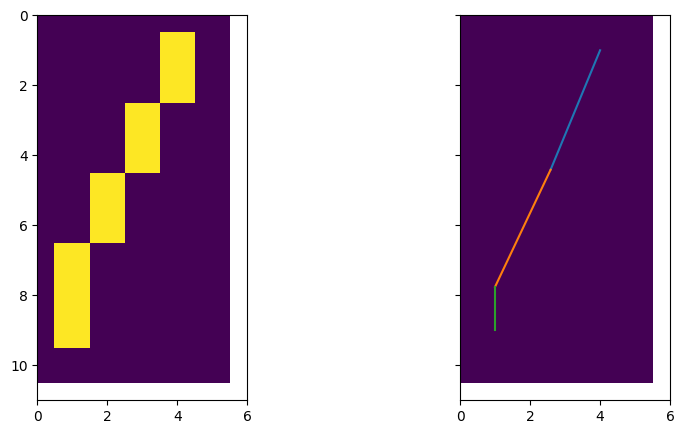

Length: 9.00, Waviness: 0.3378 



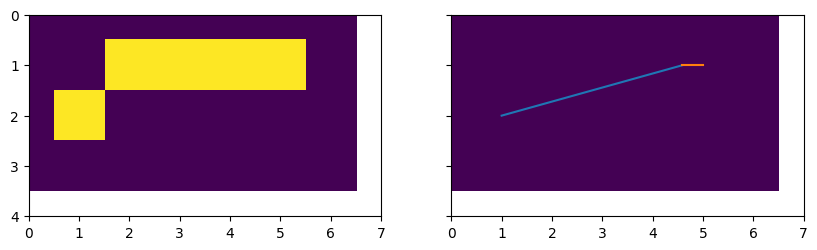

Length: 5.00, Waviness: 0.2578 



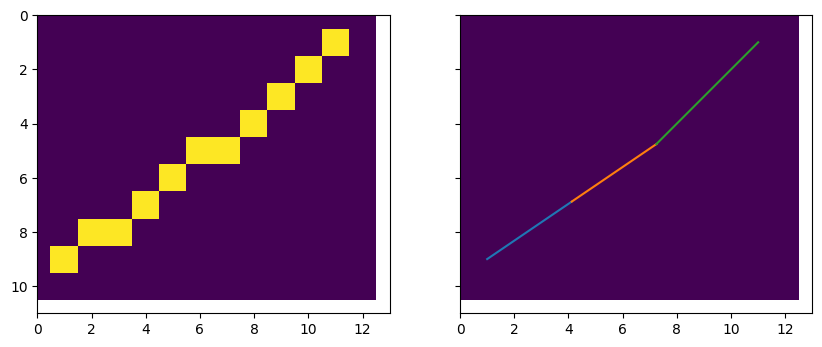

Length: 11.00, Waviness: 0.1873 



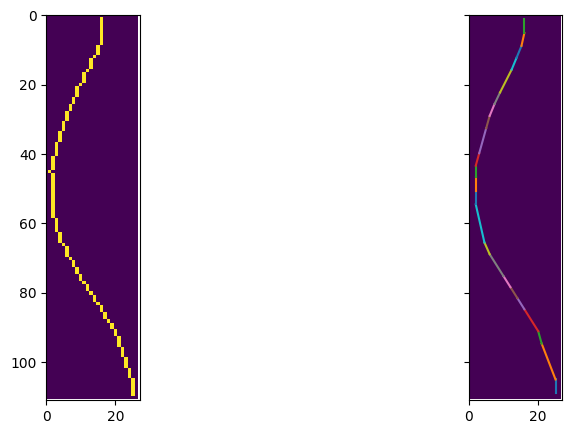

Length: 109.00, Waviness: 0.3292 



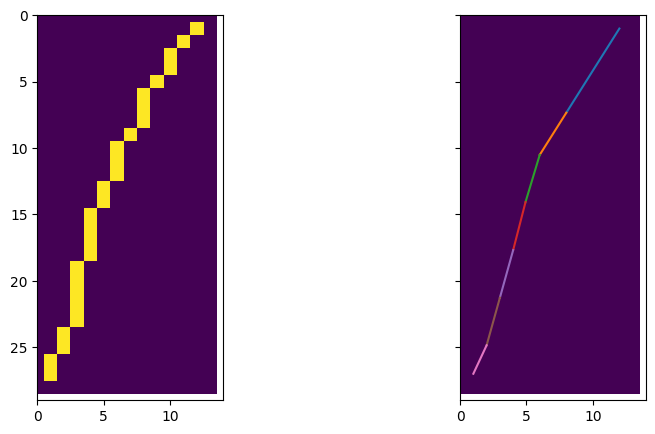

Length: 27.00, Waviness: 0.3345 



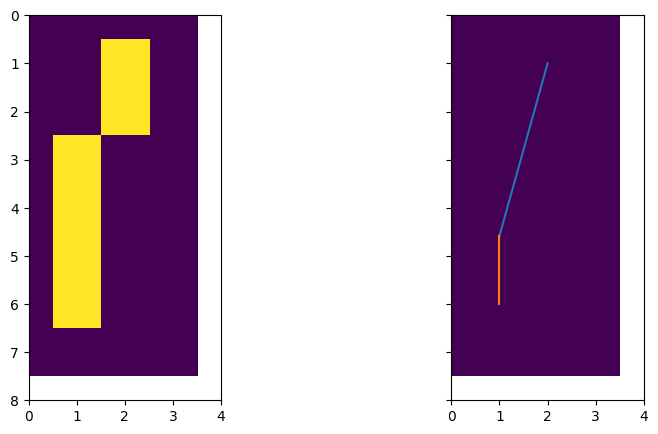

Length: 6.00, Waviness: 0.2287 



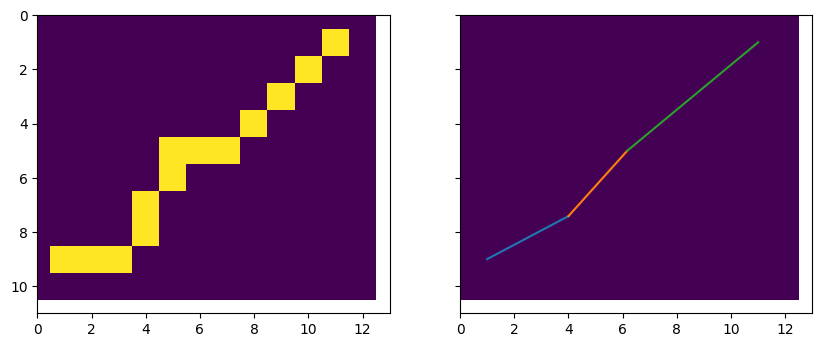

Length: 13.00, Waviness: 0.5381 



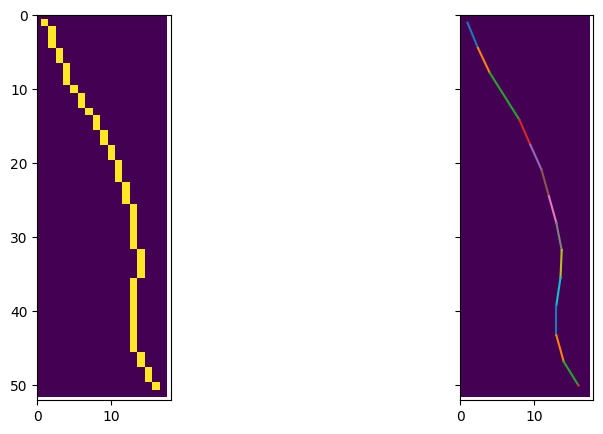

Length: 50.00, Waviness: 0.3185 



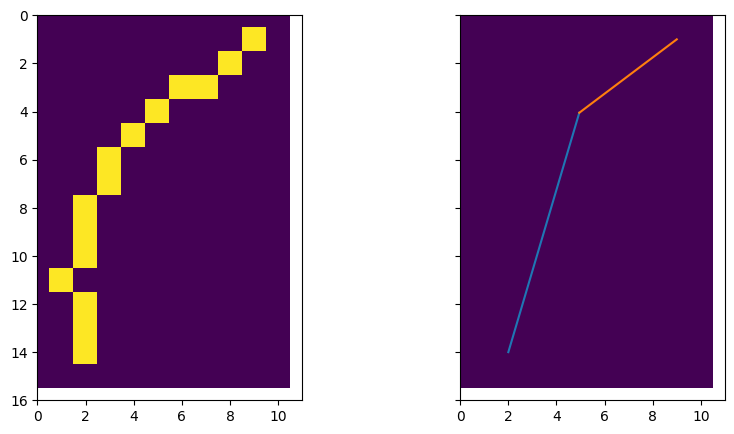

Length: 15.00, Waviness: 0.5291 



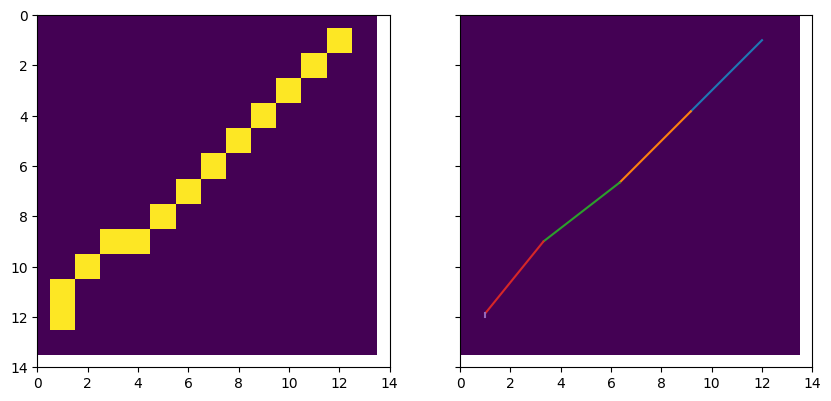

Length: 13.00, Waviness: 0.2118 



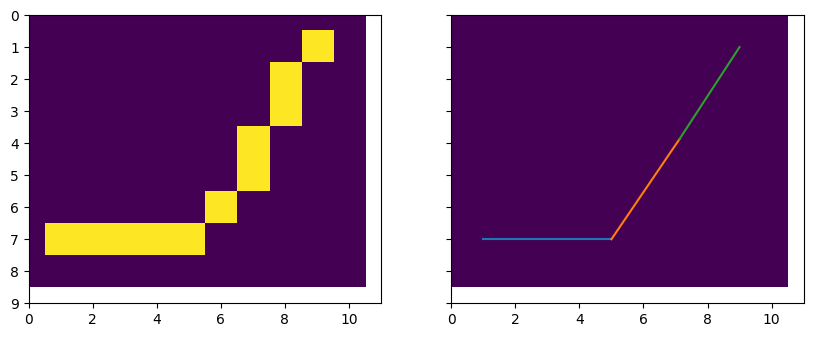

Length: 11.00, Waviness: 0.5005 



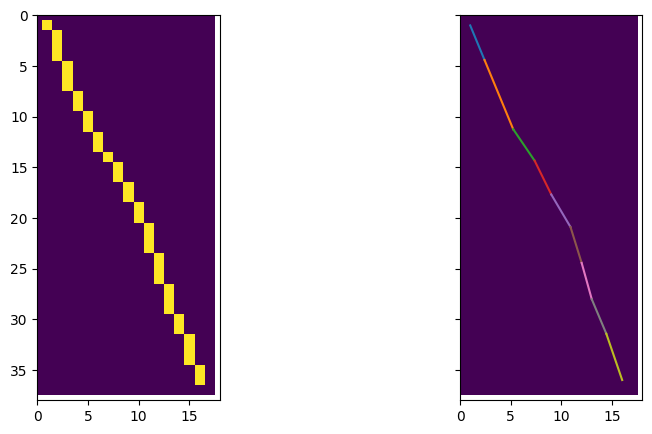

Length: 36.00, Waviness: 0.3475 



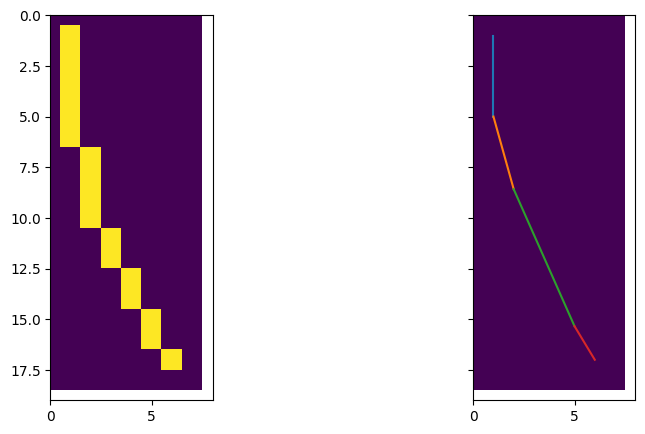

Length: 17.00, Waviness: 0.3186 



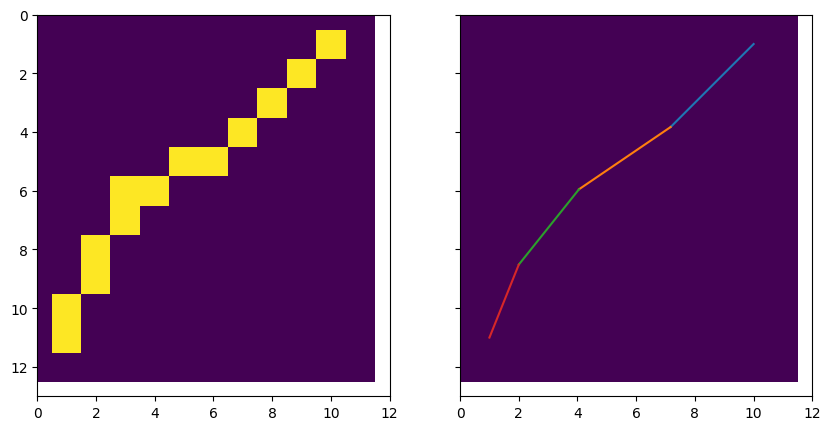

Length: 13.00, Waviness: 0.4659 



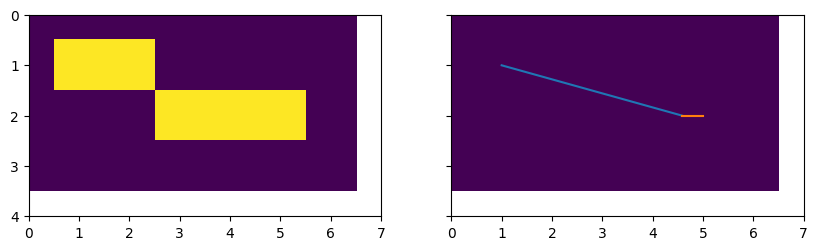

Length: 5.00, Waviness: 0.2578 



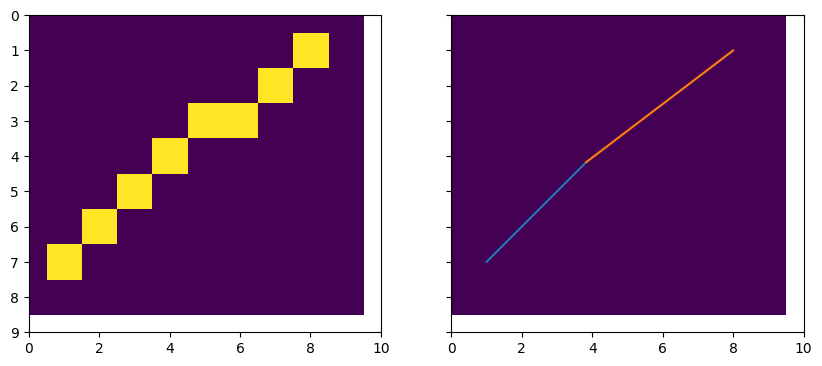

Length: 8.00, Waviness: 0.1116 



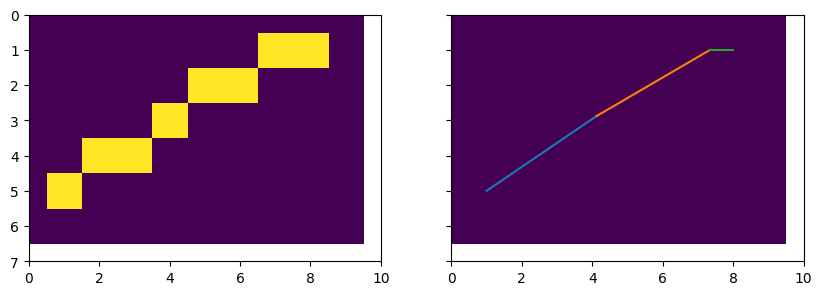

Length: 8.00, Waviness: 0.3097 



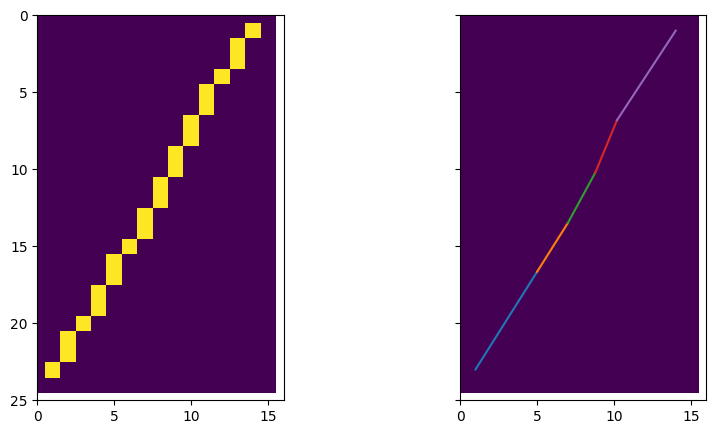

Length: 23.00, Waviness: 0.3219 



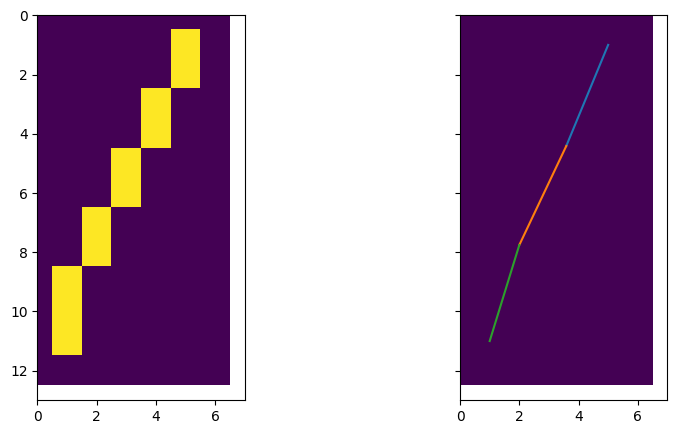

Length: 11.00, Waviness: 0.3404 



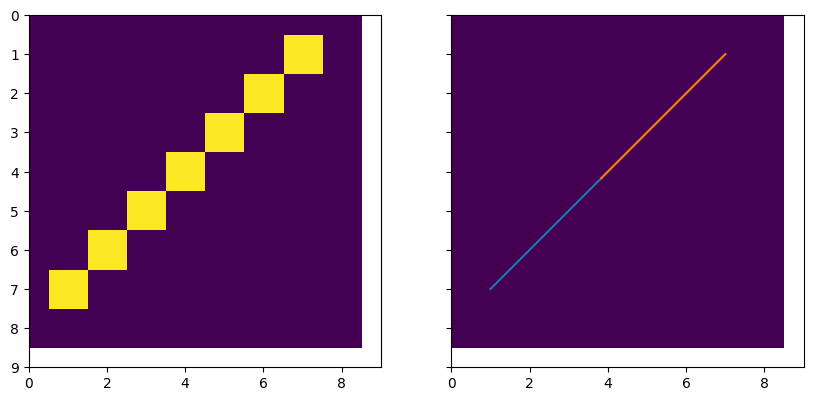

Length: 7.00, Waviness: 0.0000 



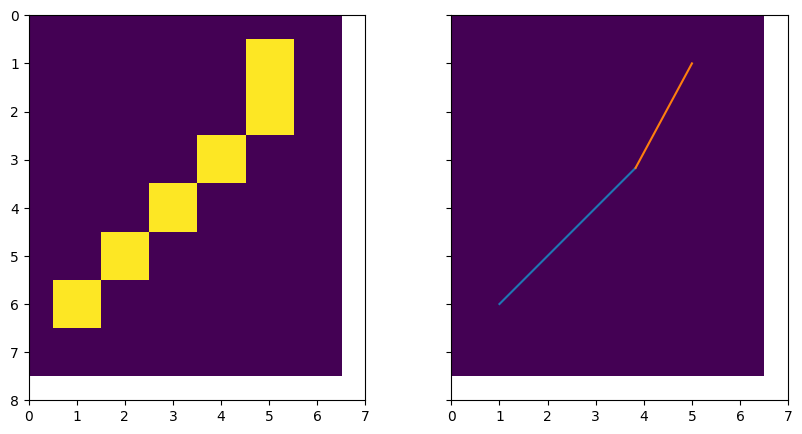

Length: 6.00, Waviness: 0.1513 



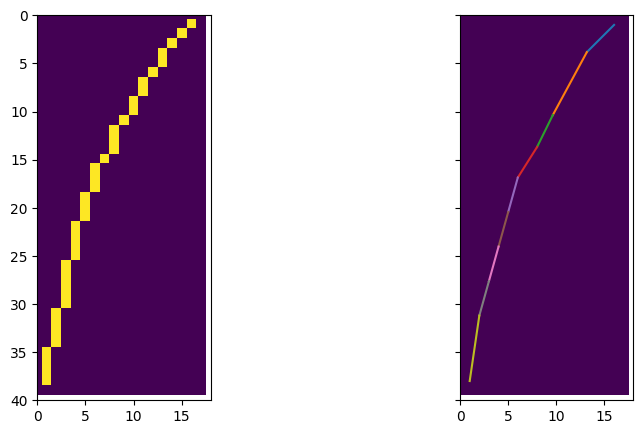

Length: 38.00, Waviness: 0.3251 



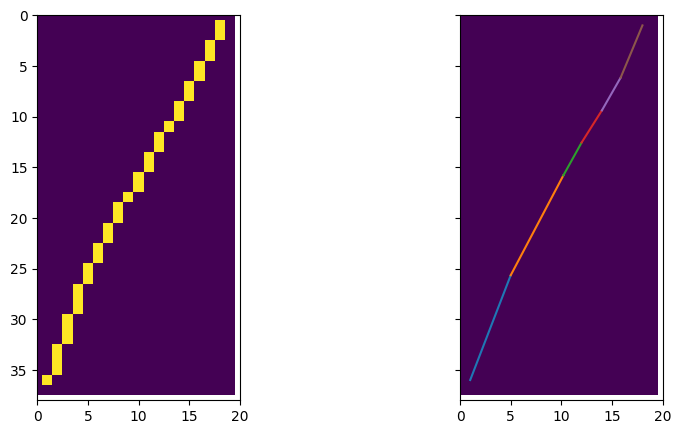

Length: 36.00, Waviness: 0.3345 



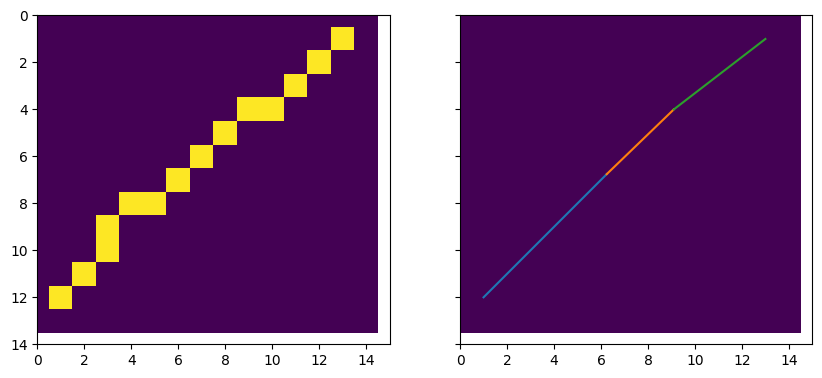

Length: 14.00, Waviness: 0.2047 



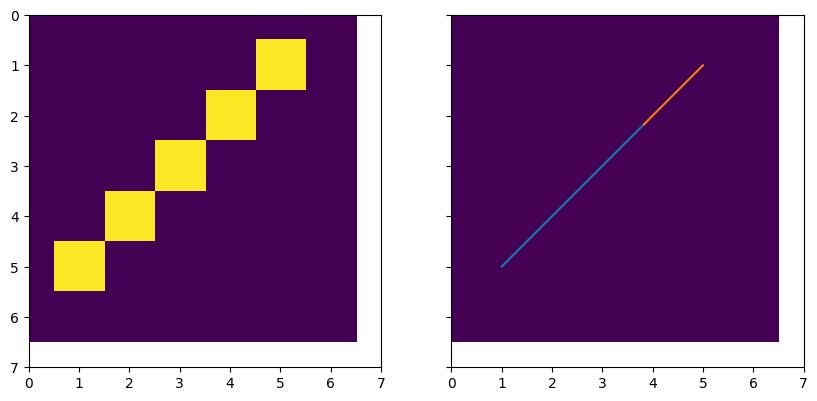

Length: 5.00, Waviness: 0.0000 



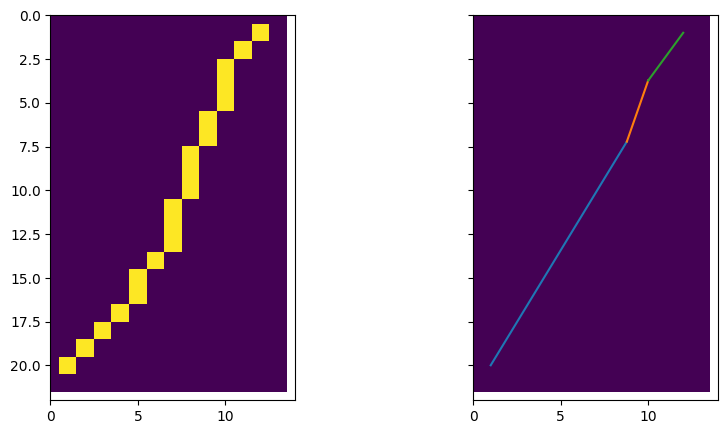

Length: 20.00, Waviness: 0.3155 



In [10]:
centerline = centerline_res
for id, region in enumerate(centerline.regions):
    plt.close('all')
    points_dist = lambda pt_0, pt_1: math.sqrt((pt_0.x-pt_1.x)**2 + (pt_0.y-pt_1.y)**2)
    segment_angle = lambda segment: math.atan2((segment.point_1.y-segment.point_0.y), (segment.point_1.x-segment.point_0.x)) # * 180 / math.pi
    fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
    ax = ax.ravel()
    region_image = np.pad(region.image, (1, 1))
    ax[0].imshow(region_image)
    points = [centerline.Point(point[1] + 1, point[0] + 1) for point in region.coords]
    points = centerline.sort_points(points)
    shape_line = LineString([(point.x, point.y) for point in points])
    seg_length = 4
    num_seg = int(np.ceil(shape_line.length / seg_length))
    split_points = [shape_line.interpolate(i * seg_length) for i in range(1, num_seg)]
    splitter = MultiPoint(split_points)

    if len(splitter.geoms) < 1:
        fragments = [shape_line]
    else:
        fragments = [frag for frag in split(shape_line, splitter).geoms if not frag.is_empty]

    seg_angles = []
    seg_lengths = []
    ax[1].imshow(region_image * 0)
    for fragment in fragments:
        sx, sy = fragment.coords.xy[0][0], fragment.coords.xy[1][0]
        ex, ey = fragment.coords.xy[0][-1], fragment.coords.xy[1][-1]
        seg_angles, seg_lengths, waviness = centerline.single_fiber_feats(fragments)
        ax[1].plot((sx, ex), (sy, ey))

    full_length = region.area
    ax[1].set_xlim((0, region_image.shape[1]))
    ax[1].set_ylim((region_image.shape[0], 0))
    plt.show()
    print(f'Length: {full_length:.2f}, Waviness: {waviness:.4f} \n')